# PESSTO I

In this jupyter notebook, we are going to present the necessary code to complete the study of the PESSTO survey with the J-VAR project.

In [1]:
# Ejecution Time
import time as time_notebook
a = time_notebook.time()

# Packages
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table, QTable, Column, vstack, join
from collections import Counter, defaultdict
from datetime import datetime, timedelta
import glob
import io
import jdcal
from lmfit import Model, Parameters
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pyphot
from scipy.interpolate import griddata
import smplotlib
import sncosmo
from synphot import SourceSpectrum, SpectralElement, Observation
from synphot.models import *
from tqdm import tqdm as tqdm
import zipfile

In [2]:
# J-VAR bands
wavelength_J0395, transmission_J0395 = np.loadtxt('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.J0395.dat', unpack=True)
J0395_band = sncosmo.Bandpass(wavelength_J0395, transmission_J0395, name='J0395')
sncosmo.registry.register(J0395_band, force=True)

wavelength_J0515, transmission_J0515 = np.loadtxt('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.J0515.dat', unpack=True)
J0515_band = sncosmo.Bandpass(wavelength_J0515, transmission_J0515, name='J0515')
sncosmo.registry.register(J0515_band, force=True)

wavelength_J0660, transmission_J0660 = np.loadtxt('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.J0660.dat', unpack=True)
J0660_band = sncosmo.Bandpass(wavelength_J0660, transmission_J0660, name='J0660')
sncosmo.registry.register(J0660_band, force=True)

wavelength_J0861, transmission_J0861 = np.loadtxt('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.J0861.dat', unpack=True)
J0861_band = sncosmo.Bandpass(wavelength_J0861, transmission_J0861, name='J0861')
sncosmo.registry.register(J0861_band, force=True)

wavelength_gsdss, transmission_gsdss = np.loadtxt('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.gSDSS.dat', unpack=True)
gsdss_band = sncosmo.Bandpass(wavelength_gsdss, transmission_gsdss, name='gsdss')
sncosmo.registry.register(gsdss_band, force=True)

wavelength_rsdss, transmission_rsdss = np.loadtxt('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.rSDSS.dat', unpack=True)
rsdss_band = sncosmo.Bandpass(wavelength_rsdss, transmission_rsdss, name='rsdss')
sncosmo.registry.register(rsdss_band, force=True)

wavelength_isdss, transmission_isdss = np.loadtxt('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.iSDSS.dat', unpack=True)
isdss_band = sncosmo.Bandpass(wavelength_isdss, transmission_isdss, name='isdss')
sncosmo.registry.register(isdss_band, force=True)

## 1. Data

Firstly, we import the data. We have two sets of data: `TRANSIENT_CLASSIFICATION`, which allows us to know the transient type of the sources, and `PESSTO_DATA`, which collects the spectra of the different sources.

### 1.1. Transient classification

We import `TRANSIENT_CLASSIFICATION`.

In [3]:
# TRANSIENT_CLASSIFICATION
TRANSIENT_CLASSIFICATION = Table.read('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/PESSTO/result_lfpk8xslfirrm7x6.fits')
TRANSIENT_CLASSIFICATION

# Filtering table columns
TRANSIENT_CLASSIFICATION = TRANSIENT_CLASSIFICATION[['TRANSIENT_ID', 'TRANSIENT_RAJ2000', 'TRANSIENT_DECJ2000', 'TRANSIENT_CLASSIFICATION_REDSHIFT', 'TRANSIENT_CLASSIFICATION', 'TRANSIENT_CLASSIFICATION_PHASE', 'TRANSIENT_CLASSIFICATION_PHASE_DAYS_LOWER_LIMIT', 'TRANSIENT_CLASSIFICATION_PHASE_DAYS_UPPER_LIMIT', 'TRANSIENT_DISCOVERY_MJD']]
TRANSIENT_CLASSIFICATION.rename_column('TRANSIENT_ID', 'OBJECT')
TRANSIENT_CLASSIFICATION

OBJECT,TRANSIENT_RAJ2000,TRANSIENT_DECJ2000,TRANSIENT_CLASSIFICATION_REDSHIFT,TRANSIENT_CLASSIFICATION,TRANSIENT_CLASSIFICATION_PHASE,TRANSIENT_CLASSIFICATION_PHASE_DAYS_LOWER_LIMIT,TRANSIENT_CLASSIFICATION_PHASE_DAYS_UPPER_LIMIT,TRANSIENT_DISCOVERY_MJD
,deg,deg,,,,d,d,d
bytes50,float32,float32,float32,bytes20,bytes20,int16,int16,int32
SN2013U,150.3,0.328416,0.03451,SN Ia,pre-max,-7,-4,56297
SN2013hf,96.291916,-37.344807,0.03,SN II,post-max,4,7,56632
chase_ESO-9015,135.52275,-64.90548,0.0056,SN II,post-max,20,--,56235
LSQ14asn,194.10487,-30.397223,0.054,SN II,post-max,20,--,56734
LSQ14dsu,305.50354,-51.796192,0.019,SN Ia,max,-3,3,56870
LSQ14drr,310.28442,-55.471138,0.04,SN IIP,post-max,20,--,56862
...,...,...,...,...,...,...,...,...
SN2019cac,207.68282,-2.5069451,0.0467,SN IIn,max,-3,3,58276


### 1.2. PESSTO data

We import `PESSTO_DATA`.

In [4]:
# PESSTO DATA
zip_path = '/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/PESSTO/archive.zip'
PESSTO_DATA = []
PESSTO_DATA_hudl = []

# Read .fits (PESSTO data) in .zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:

    file_list = zip_ref.namelist()

    for file_name in tqdm(file_list):
        if file_name.endswith('.fits'): 
            try:
                with zip_ref.open(file_name) as file:
                    file_content = io.BytesIO(file.read())

                    hdul = fits.open(file_content)
                    PESSTO_DATA_hudl.append(hdul)
                    
                    # Extract header information from the primary HDU
                    primary_header = hdul[1].header
                    
                    # Extract object name, coordinates, and observation date
                    object_name = primary_header.get('OBJECT', 'Unknown')
                    ra = primary_header.get('RA', 'Unknown')
                    dec = primary_header.get('DEC', 'Unknown')
                    observation_date = primary_header.get('TMID', 'Unknown')

                    # Try to read the table from the appropriate HDU
                    for hdu in hdul:
                        if isinstance(hdu, (fits.BinTableHDU, fits.TableHDU)):
                            data_table = QTable(hdu.data)
                            break
                    else:
                        # If no table HDU is found, continue to the next file
                        print(f"No table found in file {file_name}")
                        continue
                    
                    # Add columns to the data table for RA, DEC, TMID, and OBJECT
                    data_table['RA'] = ra
                    data_table['DEC'] = dec
                    data_table['TMID'] = observation_date
                    data_table['OBJECT'] = object_name
                    data_table['FILE'] = file_name
                    
                    PESSTO_DATA.append(data_table)
            except Exception as e:
                print(f"Error processing file {file_name}: {e}")
                pass

100%|███████████████████████████████████████| 8080/8080 [01:31<00:00, 88.49it/s]


`PESSTO_DATA` is a table of tables, with differents formats for each columns. We unifiy all them in only on table, to ease the job. This unified tables it is called `PESSTO_DATAS`.

In [5]:
def find_max_length(tables):
    """ Encuentra la longitud máxima para cada columna que es un array de float. """
    max_lengths = {}
    for table in tables:
        for col_name in table.colnames:
            col_data = table[col_name]
            if col_data.dtype.name.startswith('float') and len(col_data.shape) > 1:
                # La columna tiene una forma más de un solo elemento (es un array)
                col_length = col_data.shape[1] if len(col_data.shape) > 1 else 0
                if col_name not in max_lengths:
                    max_lengths[col_name] = col_length
                else:
                    max_lengths[col_name] = max(max_lengths[col_name], col_length)
    return max_lengths

def pad_column(column, target_length):
    """ Rellena una columna para que tenga la longitud target_length. """
    if len(column.shape) > 1:
        current_length = column.shape[1]
        if current_length < target_length:
            # Crear una matriz de valores relleno para el tamaño deseado
            dtype = column.dtype
            pad_value = np.full((target_length - current_length,), np.nan, dtype=dtype)
            padded_column = np.concatenate([column, pad_value[np.newaxis, :]], axis=1)
        else:
            padded_column = column
    else:
        # Para columnas que no son arrays de longitud variable
        padded_column = column
    return padded_column

def adjust_tables(tables, max_lengths):
    """ Ajusta todas las tablas para que las columnas tengan el tamaño máximo. """
    adjusted_tables = []
    for table in tables:
        adjusted_data = {}
        for col_name in table.colnames:
            if col_name in max_lengths:
                adjusted_data[col_name] = pad_column(table[col_name], max_lengths[col_name])
            else:
                adjusted_data[col_name] = table[col_name]
        adjusted_tables.append(QTable(adjusted_data))
    return adjusted_tables

max_lengths = find_max_length(PESSTO_DATA)
adjusted_tables = adjust_tables(PESSTO_DATA, max_lengths)
PESSTO_DATAS = vstack(adjusted_tables)
PESSTO_DATAS

WAVE,FLUX,ERR,BGFLUX,RA,DEC,TMID,OBJECT,FILE,SKYBACK
float32[1024],float32[1024],float32[1024],float32[1024],float64,float64,float64,str27,str32,float32[1024]
3337.263 .. nan,1.0211561e-16 .. nan,2.2010532e-17 .. nan,1.9656043e-16 .. nan,56.05213739333204,-26.59921522000002,58084.23878892358,AT2017int,ADP.2021-03-23T16:54:28.721.fits,-- .. --
3670.9075 .. nan,2.0795478e-18 .. nan,2.8894655e-18 .. nan,-- .. --,155.673041667,-16.9206944444,56768.1379316,LSQ14mo,ADP.2015-08-03T10:00:06.493.fits,4.1427597e-17 .. nan
3636.9175 .. nan,3.5421864e-16 .. nan,2.4905015e-17 .. nan,1.2560294e-15 .. nan,115.8141137254118,9.536598416437059,58515.20194812318,SN2019aba,ADP.2021-03-23T16:54:28.723.fits,-- .. --
3640.2964 .. nan,2.8385346e-18 .. nan,1.1735461e-17 .. nan,3.9926367e-17 .. nan,356.877125,18.06613333333333,59460.26273521882,AT2021uqz,ADP.2023-08-16T08:22:19.411.fits,-- .. --
3641.8103 .. nan,8.558262e-17 .. nan,8.697462e-18 .. nan,9.3789497e-17 .. nan,300.1677916666666,-34.79522222222222,58606.31090600093,SN2019cwt,ADP.2023-08-16T08:22:19.413.fits,-- .. --
3344.8503 .. nan,2.034502e-16 .. nan,3.781721e-17 .. nan,-- .. --,41.28729,-55.74092,56543.1856373,SN2013fc,ADP.2015-08-03T10:00:12.640.fits,6.381222e-17 .. nan
...,...,...,...,...,...,...,...,...,...
9389.317 .. 16485.336,1.2067209e-16 .. 3.455661e-17,2.9098814e-18 .. 9.457639e-19,3.015461e-17 .. 1.9239879e-17,318.2857364990522,-20.71070972437106,58364.13659597001,SN2018exb,ADP.2021-03-23T16:54:27.886.fits,-- .. --
9372.865 .. 16472.59,1.3268933e-16 .. 1.566163e-17,2.9819452e-18 .. 6.659784e-19,2.6942894e-17 .. 1.0916575e-17,330.6769088152648,-32.79263382731082,58026.19593539,SN2017gah,ADP.2021-03-23T16:54:27.884.fits,-- .. --


### 1.3. Match

In this subsection, we will do the cross-match between `TRANSIENT_CLASSIFICATION` and `PESSTO_DATA` to have only 1 table wich collects all the information we are interested in.

In [6]:
# Corrects spaces in OBJECTS names (strips)
TRANSIENT_CLASSIFICATION['OBJECT'] = [s.rstrip() for s in TRANSIENT_CLASSIFICATION['OBJECT']]
PESSTO_DATAS['OBJECT'] = [s.rstrip() for s in PESSTO_DATAS['OBJECT']]
TRANSIENT_CLASSIFICATION['TRANSIENT_CLASSIFICATION'] = [s.rstrip() for s in TRANSIENT_CLASSIFICATION['TRANSIENT_CLASSIFICATION']]

# Match
PESSTO = join(PESSTO_DATAS, TRANSIENT_CLASSIFICATION, keys='OBJECT', join_type='inner')
PESSTO.sort('OBJECT')
PESSTO.remove_columns(['BGFLUX', 'SKYBACK', 'TRANSIENT_RAJ2000', 'TRANSIENT_DECJ2000', 'FILE'])

cols_to_move_first = ['OBJECT', 'RA', 'DEC']
new_column_order = cols_to_move_first + [col for col in PESSTO.colnames if col not in cols_to_move_first]
PESSTO = PESSTO[new_column_order]

PESSTO

OBJECT,RA,DEC,WAVE,FLUX,ERR,TMID,TRANSIENT_CLASSIFICATION_REDSHIFT,TRANSIENT_CLASSIFICATION,TRANSIENT_CLASSIFICATION_PHASE,TRANSIENT_CLASSIFICATION_PHASE_DAYS_LOWER_LIMIT,TRANSIENT_CLASSIFICATION_PHASE_DAYS_UPPER_LIMIT,TRANSIENT_DISCOVERY_MJD
,,,,,,,,,,d,d,d
str27,float64,float64,float32[1024],float32[1024],float32[1024],float64,float32,str13,bytes20,float64,float64,float64
2MASXJ06192755-6553079,94.8647916667,-65.8855277778,3638.2922 .. nan,1.395055e-16 .. nan,2.8425602e-17 .. nan,58036.36231421185,0.0729,TDE,unknown,———,———,56243.0
2MASXJ14044671-2511433,211.194583333,-25.1955555556,3640.1067 .. nan,1.7322726e-16 .. nan,3.4845784e-17 .. nan,58185.3571207153,--,Galaxy,,———,———,58164.0
2MASXJ14044671-2511433,211.194583333,-25.1955555556,3641.5295 .. nan,9.69944e-17 .. nan,9.296269e-18 .. nan,58201.22991676621,--,Galaxy,,———,———,58164.0
ASASSN-14fo,308.5268,-1.96766388889,3653.0413 .. nan,2.3290977e-15 .. nan,4.184733e-17 .. nan,56886.0857349,0.024,SN Ia,max,-3.0,3.0,56884.0
ASASSN-14fw,357.278,-7.04905555556,3632.1172 .. nan,0.0 .. nan,1.1300342e-16 .. nan,56894.3634558,0.019,SN Ia,post-max,8.0,10.0,56845.0
ASASSN-14gs,249.046541667,-26.2007722222,3654.3696 .. nan,5.682665e-15 .. nan,1.5203112e-16 .. nan,56915.983769,--,CV,,———,———,56906.0
...,...,...,...,...,...,...,...,...,...,...,...,...
iPTF13dge,75.8961666667,1.5715,5988.9746 .. nan,9.31143e-16 .. nan,7.050669e-18 .. nan,56547.3284632,0.015854,SN Ia,post-max,11.0,20.0,56540.0


## 2. Data analysis

Now, it is time to analyse the `PESSTO` data (remember: this variable combines `TRANSIENT_CLASSIFICATION` and `PESSTO_DATA(S)`. We are going to analyze the number of objects for each type and the observation density (number of observations per the interval of time between the first and last spectra).

### 2.1. Transients classification

We plot the transient classification.

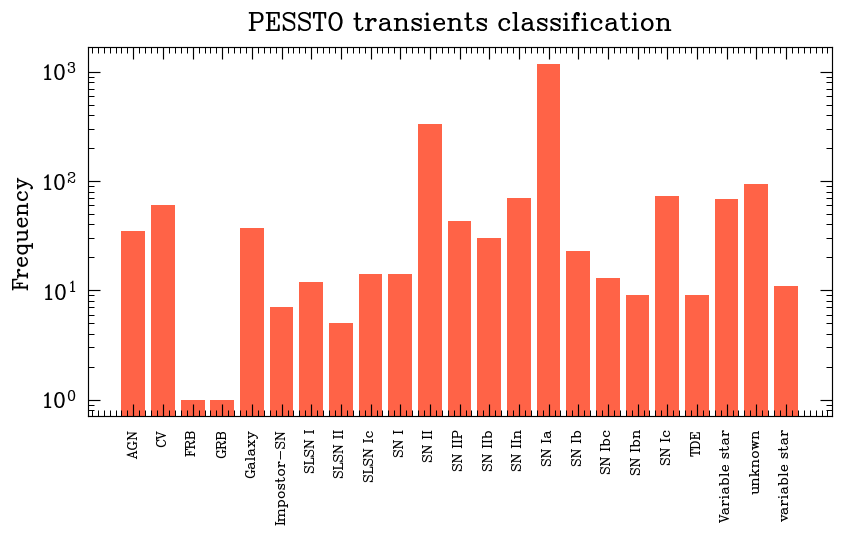

In [7]:
# Data to work with
objects = PESSTO['OBJECT']
classifications = PESSTO['TRANSIENT_CLASSIFICATION']

# Dictionary to put the classification per object
unique_objects = {}
for obj, classification in zip(objects, classifications):
    if obj not in unique_objects:
        unique_objects[obj] = classification

# Count
classification_counts = Counter(unique_objects.values())
sorted_classifications = dict(sorted(classification_counts.items()))

# Histogram (Bar) data
labels, values = zip(*sorted_classifications.items())

# Plots
plt.figure(figsize=(8, 4)) 

# Bar plot
plt.bar(labels, values, color = 'tomato', log=True)
#plt.xlabel('Classification')
plt.ylabel('Frequency')
plt.title('PESSTO transients classification')
plt.xticks(rotation=90, fontsize=10)

#plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/PESSTO_transients_classification.pdf')
plt.show()

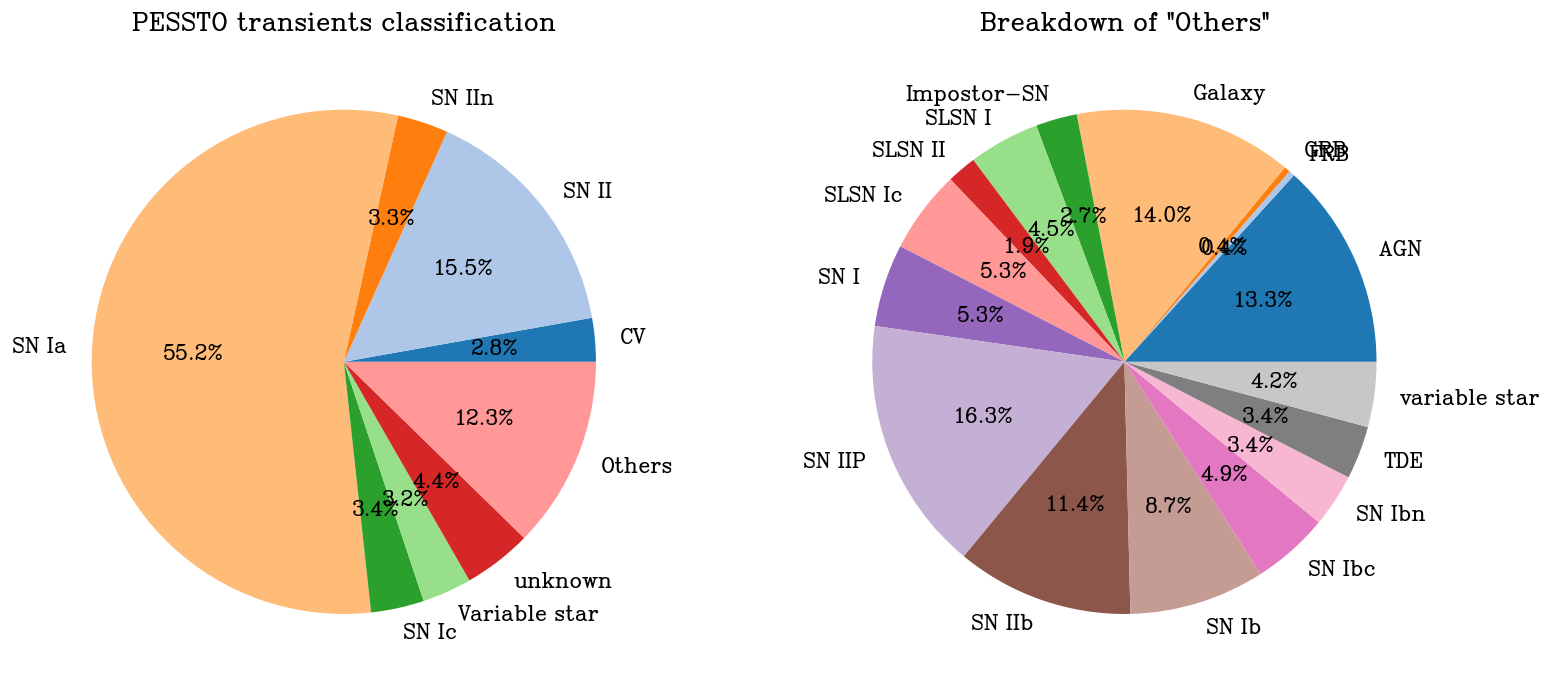

In [8]:
# Calcular el porcentaje de cada categoría
total = sum(values)
percentages = [value / total * 100 for value in values]

# Identificar las categorías con menos del 4%
threshold = 2.1
other_values = []
other_labels = []
new_values = []
new_labels = []

for value, label, percentage in zip(values, labels, percentages):
    if percentage < threshold:
        other_values.append(value)
        other_labels.append(label)
    else:
        new_values.append(value)
        new_labels.append(label)

# Agrupar las categorías menores al threshold en 'Others'
if other_values:
    new_values.append(sum(other_values))
    new_labels.append('Others')

# Crear los gráficos de pastel
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Primer gráfico de pastel (con 'Others')
ax1.pie(new_values, labels=new_labels, autopct='%1.1f%%', colors=plt.cm.tab20.colors)
ax1.set_title('PESSTO transients classification')

# Segundo gráfico de pastel (solo 'Others')
if other_values:
    ax2.pie(other_values, labels=other_labels, autopct='%1.1f%%', colors=plt.cm.tab20.colors)
    ax2.set_title('Breakdown of "Others"')
else:
    ax2.text(0.5, 0.5, 'No categories in "Others"', ha='center', va='center')
    ax2.set_title('Breakdown of "Others"')
    ax2.axis('off')

plt.tight_layout()
#plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/PESSTO_transients_classification_pie.pdf')
plt.show()

### 2.2. Top of objects with the most spectra

We make a bar plot showing the objects with more spectra.

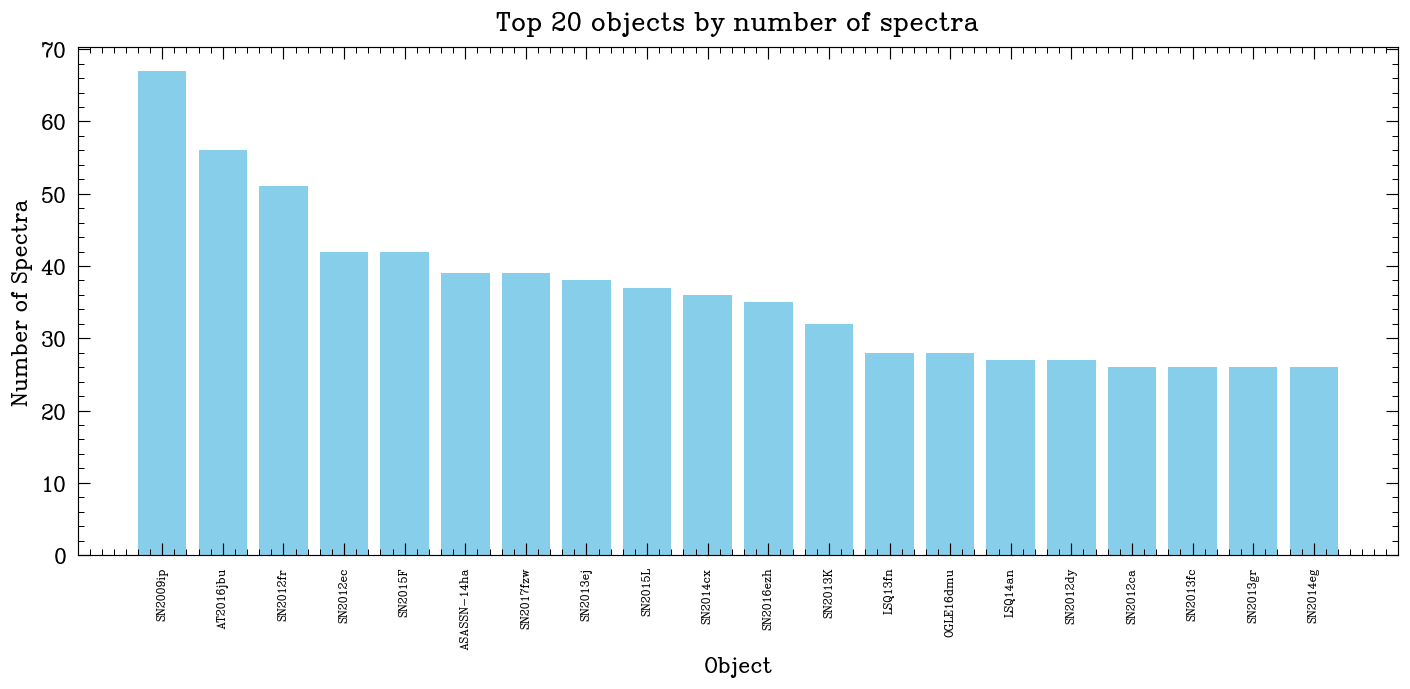

In [9]:
# Data to work with
objects = PESSTO['OBJECT']
times = PESSTO['TMID']

# Dicctionary to put the observations per object
object_observations = defaultdict(list)
for obj, timee in zip(objects, times):
    object_observations[obj].append(timee)

# Number of spectra and density of the observations
object_spectra_count = {}
object_observation_density = {}

for obj, obs_times in object_observations.items():
    n_spectra = len(obs_times)
    time_range = max(obs_times) - min(obs_times) if len(obs_times) > 1 else 1  # Avoid dividing by 0
    observation_density = n_spectra / time_range
    
    object_spectra_count[obj] = n_spectra
    object_observation_density[obj] = observation_density

# Filter the most relevant objects
top_n = 20  # top

# Filter by number of spectra
top_spectra_objects = dict(sorted(object_spectra_count.items(), key=lambda item: item[1], reverse=True)[:top_n])
top_density_objects = dict(sorted(object_observation_density.items(), key=lambda item: item[1], reverse=True)[:top_n])

# Plot Results
labels_spectra = list(top_spectra_objects.keys())
spectra_counts = list(top_spectra_objects.values())
labels_density = list(top_density_objects.keys())
observation_densities = list(top_density_objects.values())

# Plots Configuration
plt.figure(figsize=(12, 6))

plt.bar(labels_spectra, spectra_counts, color='skyblue')
plt.xlabel('Object')
plt.ylabel('Number of Spectra')
plt.title(f'Top {top_n} objects by number of spectra')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
#plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/PESSTO_top50_objects.pdf')
plt.show()

### 2.3. Number of spectra per class

Average number of spectra per classification.

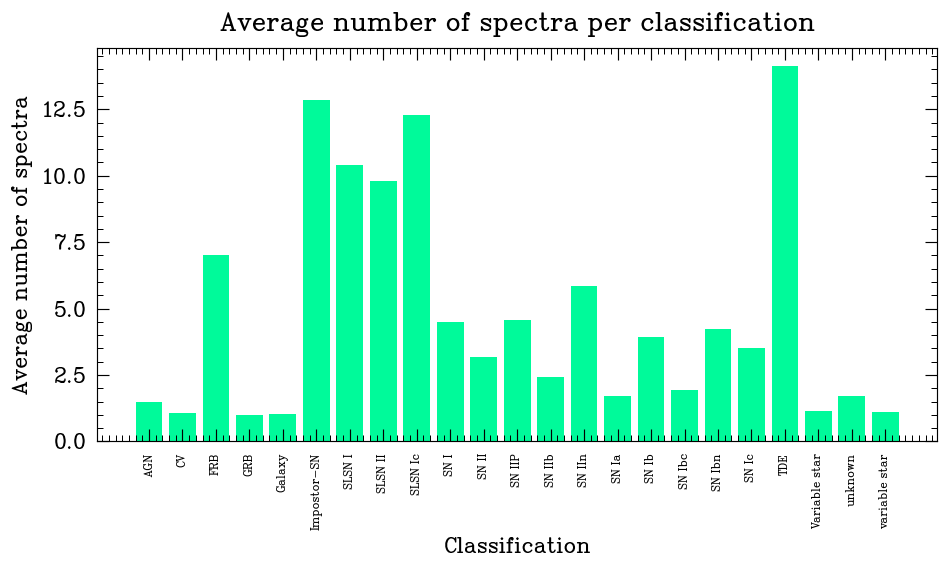

In [10]:
# Group data by transient classification
classification_spectra_count = defaultdict(list)
classification_observation_density = defaultdict(list)

for obj in object_spectra_count:
    classification = PESSTO[PESSTO['OBJECT'] == obj]['TRANSIENT_CLASSIFICATION'][0]
    classification_spectra_count[classification].append(object_spectra_count[obj])
    classification_observation_density[classification].append(object_observation_density[obj])

# Calculate averages by classification
avg_spectra_count = {classification: np.mean(counts) for classification, counts in classification_spectra_count.items()}
avg_observation_density = {classification: np.mean(densities) for classification, densities in classification_observation_density.items()}

# Sort classifications alphabetically
sorted_classifications = sorted(avg_spectra_count.keys())
sorted_avg_spectra_counts = [avg_spectra_count[cls] for cls in sorted_classifications]
sorted_avg_observation_densities = [avg_observation_density[cls] for cls in sorted_classifications]

# Plots Configuration
plt.figure(figsize=(8, 5))

plt.bar(sorted_classifications, sorted_avg_spectra_counts, color='mediumspringgreen')
plt.xlabel('Classification')
plt.ylabel('Average number of spectra')
plt.title('Average number of spectra per classification')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
#plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/average_number_spectra_per_class.pdf')
plt.show()

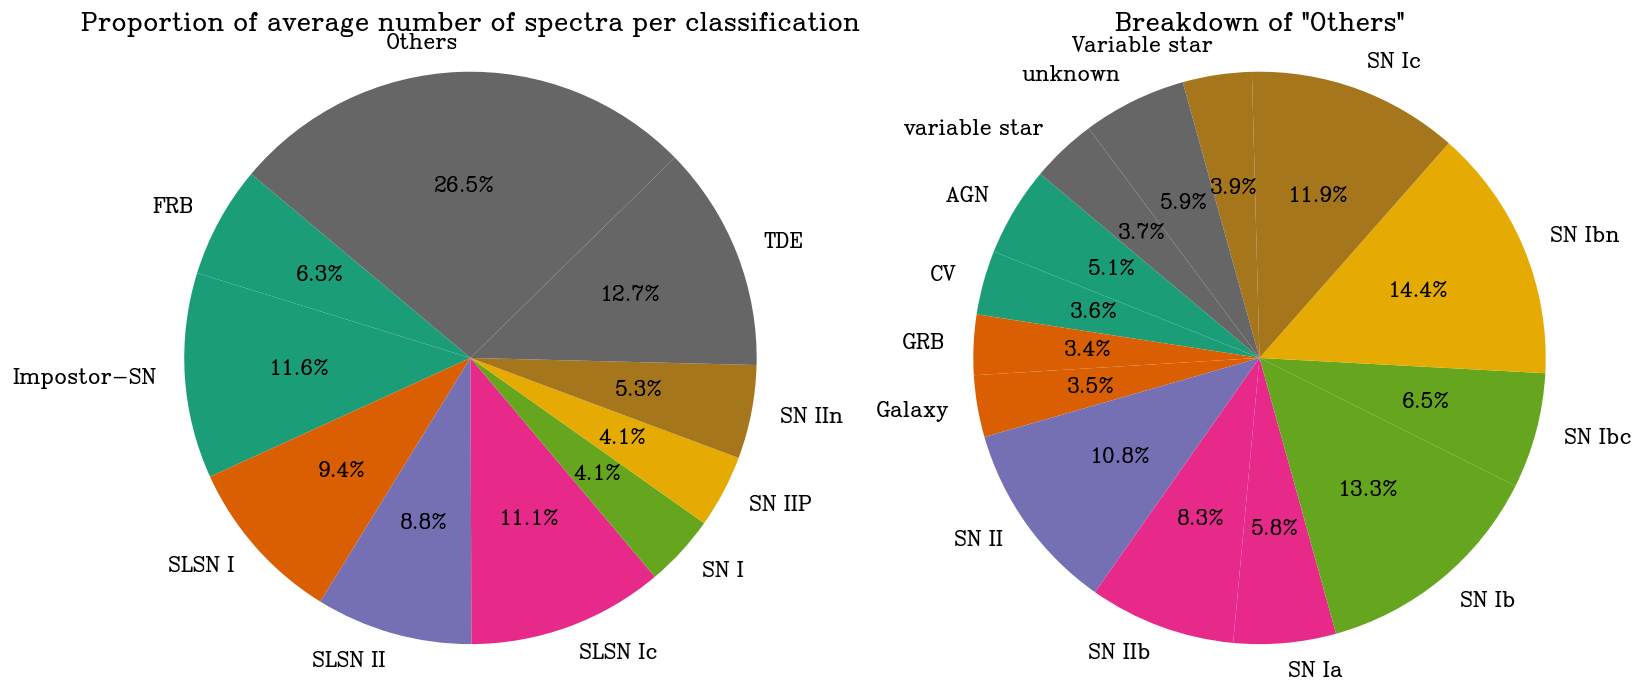

In [11]:
# Calcular el porcentaje de cada categoría
total = sum(sorted_avg_spectra_counts)
percentages = [value / total * 100 for value in sorted_avg_spectra_counts]

# Identificar las categorías con menos del 4%
threshold = 4
other_values = []
other_labels = []
new_values = []
new_labels = []

for value, label, percentage in zip(sorted_avg_spectra_counts, sorted_classifications, percentages):
    if percentage < threshold:
        other_values.append(value)
        other_labels.append(label)
    else:
        new_values.append(value)
        new_labels.append(label)

# Agrupar las categorías menores al threshold en 'Others'
if other_values:
    new_values.append(sum(other_values))
    new_labels.append('Others')

# Crear los gráficos de pastel
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Primer gráfico de pastel (con 'Others')
ax1.pie(new_values, labels=new_labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Dark2(np.linspace(0, 1, len(new_labels))))
ax1.set_title('Proportion of average number of spectra per classification')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Segundo gráfico de pastel (solo 'Others')
if other_values:
    ax2.pie(other_values, labels=other_labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Dark2(np.linspace(0, 1, len(other_labels))))
    ax2.set_title('Breakdown of "Others"')
    ax2.axis('equal')
else:
    ax2.text(0.5, 0.5, 'No categories in "Others"', ha='center', va='center')
    ax2.set_title('Breakdown of "Others"')
    ax2.axis('off')

plt.tight_layout()
#plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/average_number_spectra_per_class_pie.pdf')
plt.show()

### 2.4. Object with more spectra per class

Now, we are interested in knowing which is the object with more spectra for each class.

In [12]:
# Convert the Astropy table to a list of dictionaries
data = [dict(row) for row in PESSTO]

# Create a dictionary to count the number of spectra per class and object
spectra_counts = defaultdict(Counter)

for row in data:
    classification = row['TRANSIENT_CLASSIFICATION']
    obj = row['OBJECT']
    spectra_counts[classification][obj] += 1

# Get the top three objects with the most spectra for each class
top_objects = {}
for classification, objects in spectra_counts.items():
    # Get the top three objects with the most spectra for the current classification
    top_3_objects = objects.most_common(3)
    top_objects[classification] = top_3_objects

# Print the results
for classification, objects in top_objects.items():
    print(f"Class: {classification}")
    for obj, count in objects:
        print(f"  Object: {obj}, Spectra: {count}")

Class: TDE
  Object: SN2015L, Spectra: 37
  Object: AT2018dyb, Spectra: 23
  Object: AT2018fyk, Spectra: 21
Class: Galaxy
  Object: 2MASXJ14044671-2511433, Spectra: 2
  Object: AT2016hhr, Spectra: 1
  Object: AT2017gdu, Spectra: 1
Class: SN Ia
  Object: SN2012fr, Spectra: 51
  Object: SN2015F, Spectra: 42
  Object: SN2017fzw, Spectra: 39
Class: CV
  Object: AT2018est, Spectra: 2
  Object: AT2018fdx, Spectra: 2
  Object: LSQ14efq, Spectra: 2
Class: SN II
  Object: ASASSN-14ha, Spectra: 39
  Object: SN2013ej, Spectra: 38
  Object: SN2014cx, Spectra: 36
Class: SN IIn
  Object: SN2009ip, Spectra: 67
  Object: LSQ13fn, Spectra: 28
  Object: SN2012ca, Spectra: 26
Class: SN IIb
  Object: SN2013bb, Spectra: 14
  Object: SN2013fq, Spectra: 11
  Object: SN2018gjx, Spectra: 8
Class: SN Ib
  Object: SN2016adj, Spectra: 25
  Object: SN2015ah, Spectra: 10
  Object: SN2015ap, Spectra: 10
Class: SN Ic
  Object: SN2017iuk, Spectra: 25
  Object: SN2016iae, Spectra: 17
  Object: LSQ12dyw, Spectra: 16
Cla

## 3. Spectra

We plot the spectrums of an object from `PESSTO` as an example.

### 3.1. Spectrum

We plot just one spectrum of an object in a determined time.

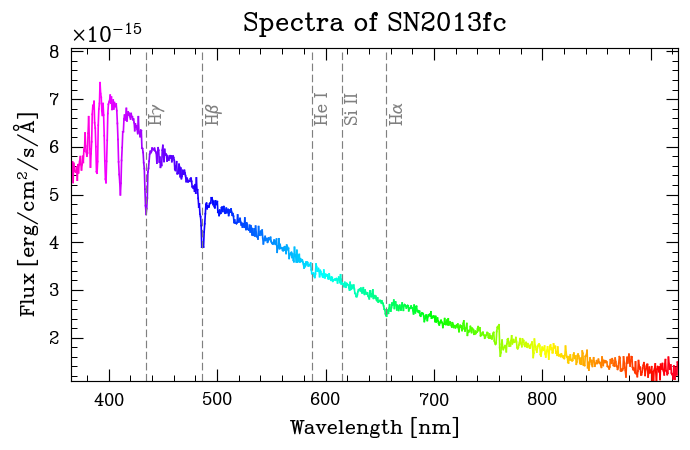

In [13]:
# Object slection
j = 5

# Data: wavelengths and fluxes
wave = PESSTO['WAVE'][j] / 10  # Convert from Å to nm
flux = PESSTO['FLUX'][j]

# Create the figure
fig, ax = plt.subplots(figsize=(6, 4))

# Normalize the wavelength data for the colormap
norm = plt.Normalize(min(wave), max(wave))
cmap = cm.get_cmap('gist_rainbow_r')

# Create a gradient along the spectrum
for i in range(len(wave) - 1):
    # Plot segments with colors based on wavelength
    ax.plot(wave[i:i+2], flux[i:i+2], color=cmap(norm(wave[i])), linewidth=1)

# Titles
ax.set_title(f'Spectra of {PESSTO_DATAS["OBJECT"][j]}', fontsize=18)
ax.set_xlabel('Wavelength [nm]', fontsize=14)  # Updated label to nm
ax.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize=14)

# Limits
ax.set_xlim(min(wave), max(wave))
ax.set_ylim(min(flux) * 1.1, max(flux) * 1.1)

# Important Lines
important_lines = {
    'Hα': 656.279,
    'Hβ': 486.135,
    'Hγ': 434.0472,
    'He I': 587.59663,
    'Si II': 615.0
}

# Plot important lines
for line_name, line_wave in important_lines.items():
    ax.axvline(x=line_wave, color='gray', linestyle='--', linewidth=0.7)
    ax.text(line_wave*1.005, ax.get_ylim()[1]*0.8, line_name, rotation=90, verticalalignment='bottom', fontsize=12, color='gray')

# Axis formatting
ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust layout and show the plot
plt.tight_layout()
#plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/spectra_example.pdf')
plt.show()

### 3.2. Spectra in time

We plot the spectra of a source as a function of the time. 

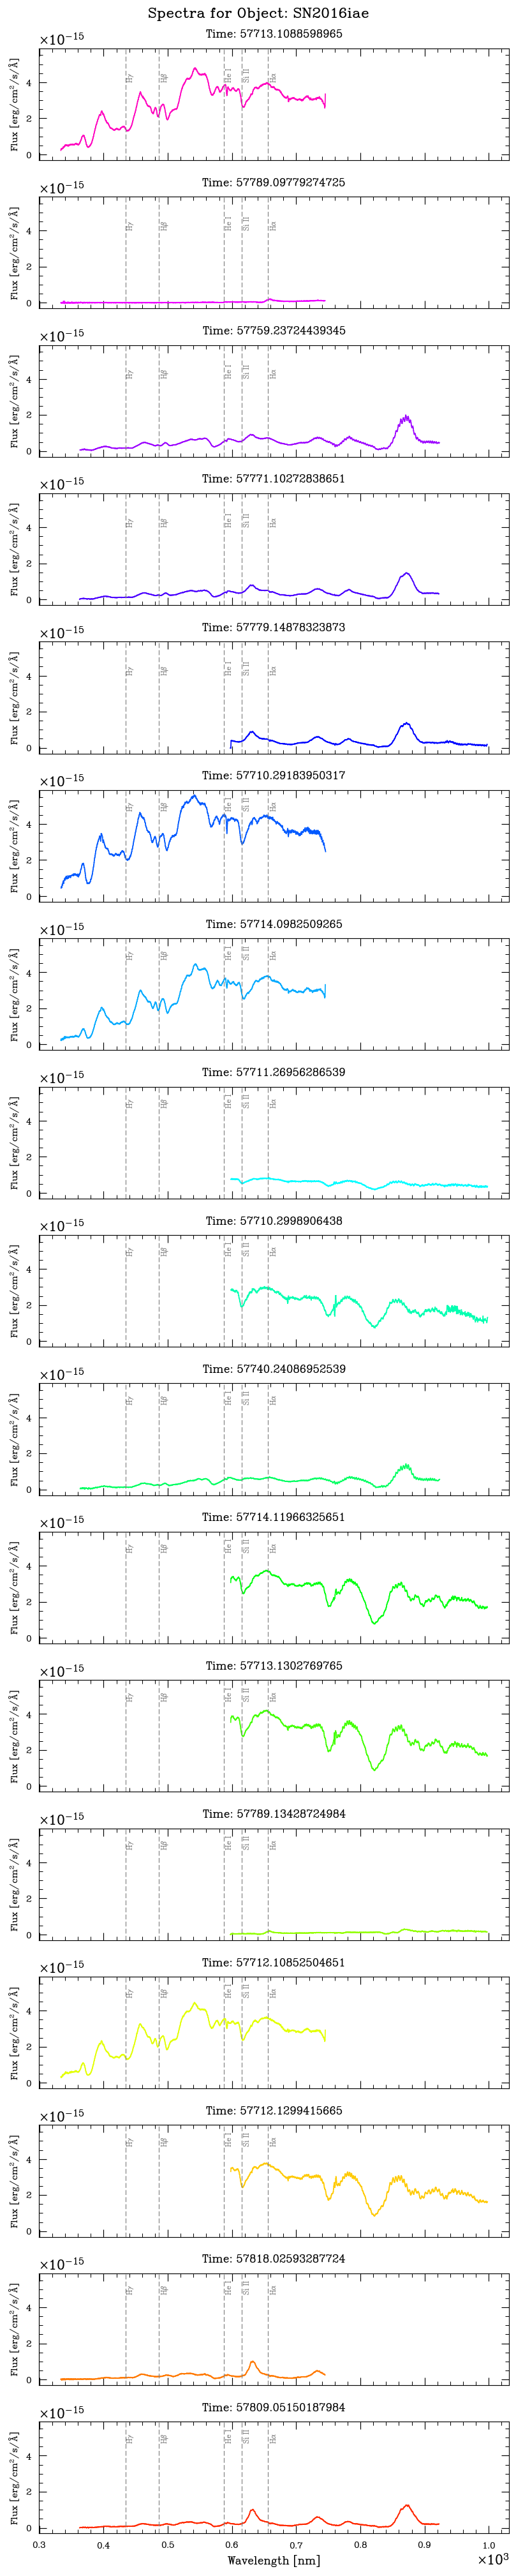

In [14]:
# Choose object
object_name = 'SN2016iae' # SN2016iae

# Get the indexes for the selected object
indices = [i for i, obj in enumerate(PESSTO['OBJECT']) if obj == object_name]

# Create the figure with subgraphs
fig, axs = plt.subplots(len(indices), 1, figsize=(7, 2 * len(indices)), sharex=True, sharey=True)

# Define the colormap
norm = plt.Normalize(0, len(indices))
cmap = cm.get_cmap('gist_rainbow_r')

# Convert from Å to nm
important_lines = {
    'Hα': 656.279,
    'Hβ': 486.135,
    'Hγ': 434.0472,
    'He I': 587.59663,
    'Si II': 615.0
}

# Iterate over each index and plot the spectrum
for idx, ax in zip(indices, axs):
    wave = PESSTO['WAVE'][idx] / 10  # Convert from Å to nm
    flux = PESSTO['FLUX'][idx]
    
    # Creates a gradient along the spectrum
    for i in range(len(wave) - 1):
        # Plot segments with colors based on wavelength
        ax.plot(wave[i:i+2], flux[i:i+2], color=cmap(norm(indices.index(idx))), linewidth=1)
    
    # Tittles
    ax.set_title(f'Time: {PESSTO["TMID"][idx]}', fontsize=12)
    ax.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize=10)
    
    # Plot important lines
    for line_name, line_wave in important_lines.items():
        ax.axvline(x=line_wave, color='gray', linestyle='--', linewidth=0.7)
        ax.text(line_wave * 1.005, ax.get_ylim()[1] * 0.8, line_name, rotation=90, verticalalignment='bottom', fontsize=8, color='gray')

# Common x-axis label
axs[-1].set_xlabel('Wavelength [nm]', fontsize=12)

# Adds the global title to the figure
fig.suptitle(f'Spectra for Object: {object_name}', fontsize=16, y=0.99)

# Tick ​​format
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=10)

# Adjust the layout and display the graph
plt.tight_layout()
#plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/spectra_vs_time.pdf')
plt.show()

Same plot but in an other way.

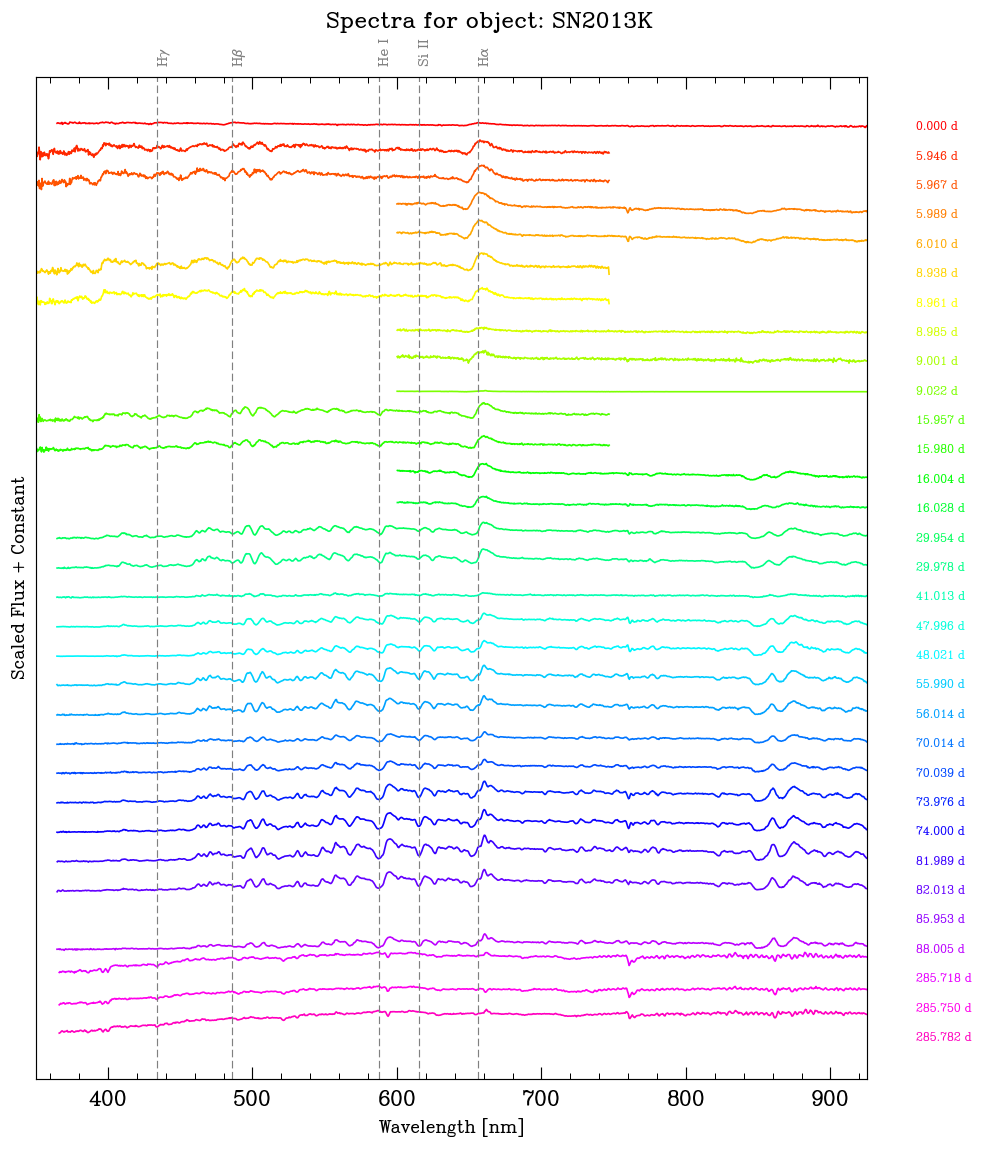

In [15]:
# Choose object
object_name = 'SN2013K' # SN2013K

# Get the indexes for the selected object
indices = [i for i, obj in enumerate(PESSTO['OBJECT']) if obj == object_name]

# Sort indices based on PESSTO["TMID"] values, in descending order
indices.sort(key=lambda idx: PESSTO["TMID"][idx], reverse=True)

# Create the figure
fig, ax = plt.subplots(figsize=(10, 10))

# Define the colormap
norm = plt.Normalize(0, len(indices))
cmap = cm.get_cmap('gist_rainbow_r')

# Convert from Å to nm
important_lines = {
    'Hα': 656.279,
    'Hβ': 486.135,
    'Hγ': 434.0472,
    'He I': 587.59663,
    'Si II': 615.0
}

# Search of max wavelength
maxs = []
tmin = []
for i, idx in enumerate(indices):
    wave = PESSTO['WAVE'][idx] / 10  # Convert from Å to nm
    flux = PESSTO['FLUX'][idx]
    time = PESSTO["TMID"][idx]

    maxs.append(max(wave))
    tmin.append(time)

# Iterate over each index and plot the spectrum
for i, idx in enumerate(indices):
    wave = PESSTO['WAVE'][idx] / 10  # Convert from Å to nm
    flux = PESSTO['FLUX'][idx]
    
    # Offset each spectrum vertically
    offset = i * 8.  # Adjust this value to control the separation between spectra # 10
    ax.plot(wave, flux * 10**16. + offset, color=cmap(norm(i)), linewidth=1)
    
    # Add date text to the right of the spectrum, outside the visible plot area
    ax.text(max(maxs) - 685, offset, f'{PESSTO["TMID"][idx]-min(tmin):.3f} d', color=cmap(norm(i)), verticalalignment='center', fontsize=8)

# Plot important lines
for line_name, line_wave in important_lines.items():
    ax.axvline(x=line_wave, color='gray', linestyle='--', linewidth=0.7)
    ax.text(line_wave, ax.get_ylim()[1]+2.8, line_name, rotation=90, verticalalignment='bottom', fontsize=10, color='gray')

# Labels and title
ax.set_xlabel('Wavelength [nm]', fontsize=12)
ax.set_ylabel('Scaled Flux + Constant', fontsize=12)
ax.yaxis.set_ticks([])
ax.yaxis.set_ticklabels([])
ax.set_xlim(350,925)

# Set x-axis format to display values as 300, 400, 500, etc.
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

fig.suptitle(f'Spectra for object: {object_name}', fontsize=16, y=0.96, x=0.42)  # Adjust y to bring the title closer

# Adjust the layout and display the graph
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust rect to make space for the legend

#plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/spectra_vs_time2.pdf')
plt.show()

### 3.3. Spectra plane

We plot here the spectra as a plane as a function of time and wavelength.

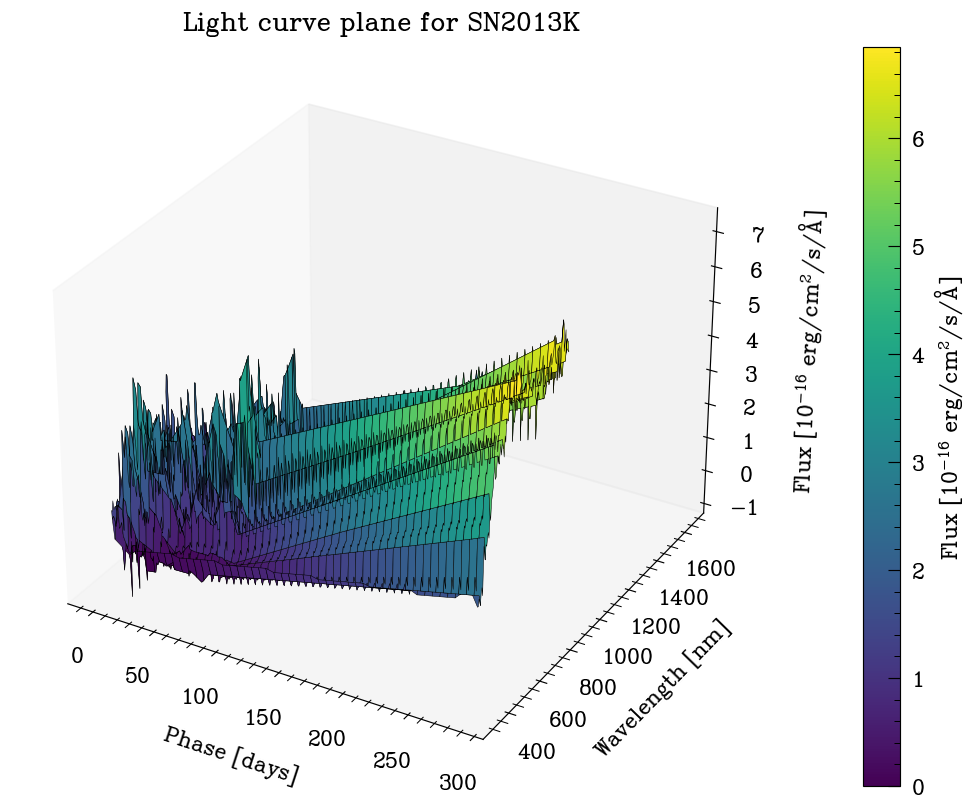

In [16]:
# Filter the table to get only the rows corresponding to the object SN2017ens
object_name = 'SN2013K'
filtered_data = PESSTO[PESSTO['OBJECT'] == object_name]

# Extract the necessary data
wavelengths = filtered_data['WAVE'] / 10
fluxes = filtered_data['FLUX']
times = filtered_data['TMID']

# Ensure the data is in the correct format for 3D plotting
time_list = []
wavelength_list = []
flux_list = []

# Iterate over observations and add data to lists
for i, time in enumerate(times):
    valid_indices = ~np.isnan(wavelengths[i]) & ~np.isnan(fluxes[i])
    time_list.extend([time] * np.sum(valid_indices))
    wavelength_list.extend(np.array(wavelengths[i])[valid_indices])
    flux_list.extend(np.array(fluxes[i])[valid_indices])

# Convert lists to NumPy arrays
time_array = np.array(time_list)
wavelength_array = np.array(wavelength_list)
flux_array = np.array(flux_list)

# Create a grid of time and wavelength values
time_grid, wavelength_grid = np.meshgrid(
    np.linspace(time_array.min(), time_array.max(), 300),
    np.linspace(wavelength_array.min(), wavelength_array.max(), 300)
)

# Interpolate the flux values on the grid
flux_grid = griddata(
    (time_array, wavelength_array),
    flux_array,
    (time_grid, wavelength_grid),
    method='linear'
)

# Set up the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(time_grid-np.min(time_grid), wavelength_grid, flux_grid*10**16, cmap='viridis', edgecolor='black', linewidth=0.3)

# Add labels and title
ax.grid(False)
ax.set_xlabel('Phase [days]', labelpad=15)
ax.set_ylabel('Wavelength [nm]', labelpad=15)
ax.set_zlabel('Flux [10$^{-16}$ erg/cm$^2$/s/Å]', labelpad=15)
ax.set_title(f'Light curve plane for {object_name}')
#ax.set_ylim(350,950)

# Format the wavelength axis
ax.ticklabel_format(axis='y', style='plain')

# Add a color bar
cbar = plt.colorbar(surf, shrink=1., aspect=20, pad=0.1)
cbar.set_label('Flux [10$^{-16}$ erg/cm$^2$/s/Å]')

#plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/light_curve_plane.pdf')
plt.show()

## 4. SNIIP

In this section, we are going to apply the `sncosmo` packages to fit the light curves of the 3 SNIIP with more spectra. This fit is going to be done using two things: spectrums and synthetic photometry. The first is collected in the `PESSTO` astropy table. The latter must be calculated from the spectra using the `synphot` or `sncosmo` packages (which allows the calculation of magnitudes from spectra).

### 4.1. SNIIPs selection

First, we select the 3 SNIIPs with the most spectra. These samples will be the SNs to work with.

In [17]:
# Select data
SN2012ec = PESSTO[PESSTO['OBJECT'] == 'SN2012ec'] # SN2012ec
SN2013K = PESSTO[PESSTO['OBJECT'] == 'SN2013K'] # SN2013K
SN2013fs = PESSTO[PESSTO['OBJECT'] == 'SN2013fs'] # SN2013fs

### 4.2. Light curves using synthetic photometry (sncosmo)

In this subsection, we plot the light curves using the magnitudes of each band derivated using `sncosmo` package. For this, we have created first the function `calculate_bandflux_table` that, giving the name of the SN and the bands that we are interested in, returns a table with the magnitudes for the different bands as a function of time. 

In [18]:
### Function to calculate magnitudes from the spectra of a SN
def calculate_bandflux_table(supernova_data, bands):
    # List to store results
    time_list = []
    flux_dict = {band: [] for band in bands}
    mag_dict = {band: [] for band in bands}

    # Loop through the data
    for i in range(len(supernova_data['TMID'])):
        wave = supernova_data['WAVE'][i] 
        flux = supernova_data['FLUX'][i] # - supernova_data['SKYBACK'][i] - supernova_data['BGFLUX'][i] ??
        fluxerr = supernova_data['ERR'][i]
        time = supernova_data['TMID'][i]

        # Filter NaN values
        mask = ~np.isnan(wave) & ~np.isnan(flux) & ~np.isnan(fluxerr)
        wave_clean = wave[mask]
        flux_clean = flux[mask]
        fluxerr_clean = fluxerr[mask]

        # Create Spectrum object
        spectrum = sncosmo.Spectrum(wave_clean, flux_clean, fluxerr_clean, wave_unit=u.Angstrom)

        # Add time
        time_list.append(time)

        # Calculate bandflux for each band
        for band, zp in zip(bands, zp_bands):
            try:
                flux = spectrum.bandflux(band, zpsys='ab', zp=zp)
                mag =  spectrum.bandmag(band, magsys='ab') # ab.band_flux_to_mag(flux, band)
            except ValueError:
                flux = np.nan  # Assign NaN in case of error
                mag = np.nan

            # Add flux to the dictionary
            flux_dict[band].append(flux)
            mag_dict[band].append(mag)

    # Create an astropy table for the results
    columns = [time_list] + [flux_dict[band] for band in bands] + [mag_dict[band] for band in bands]
    names = ['time'] + [f"{band}_flux" for band in bands] + [f"{band}_mag" for band in bands]
    table = Table(columns, names=names)
    table.sort('time')
    return table

# List of bands
bands = ['J0395', 'J0515', 'J0660', 'J0861', 'gsdss', 'rsdss', 'isdss']
zp_bands = [20.5018, 21.640049, 21.1636, 21.67545, 23.688549, 23.7042, 23.384201]

# Calculate tables for each supernova
SN2012ec_sncosmo = calculate_bandflux_table(SN2012ec, bands)
SN2013K_sncosmo = calculate_bandflux_table(SN2013K, bands)
SN2013fs_sncosmo = calculate_bandflux_table(SN2013fs, bands)
SN2013fs_sncosmo[0:5]

time,J0395_flux,J0515_flux,J0660_flux,J0861_flux,gsdss_flux,rsdss_flux,isdss_flux,J0395_mag,J0515_mag,J0660_mag,J0861_mag,gsdss_mag,rsdss_mag,isdss_mag
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
56575.0513684,137.76410954940695,362.23660228556855,189.66691333535252,nan,2458.799998991706,2034.0246024648088,nan,15.153959776369302,15.242568171032925,15.468621058771326,nan,15.211740989323186,15.43330949597408,nan
56579.0955049,1.3094265622732166,108.32648454833753,203.64128544362524,nan,2025.0072645839114,2014.5338839510573,nan,20.209097133692232,16.553212376280168,15.391435425579193,nan,15.422482536107175,15.443763558726722,nan
56581.0821257,11.73330035956738,26.854787966865498,13.230444710145315,nan,160.8045341715611,131.54189532713025,nan,17.82824952931364,18.06749468066431,18.35966389446015,nan,18.17280327426235,18.406539762201792,nan
56581.0931223,nan,nan,10.994563589473016,-25.217400544909506,nan,nan,-12.552351724018328,nan,nan,18.56065501135716,nan,nan,nan,nan
56600.1589835,17.19991480572869,108.26159377169425,158.54219829316946,nan,647.9207588544114,917.6243088411135,nan,17.412984260564496,16.553862959342826,15.663237810796588,nan,16.65974426347402,16.29753772508247,nan


We make the light curves plots.

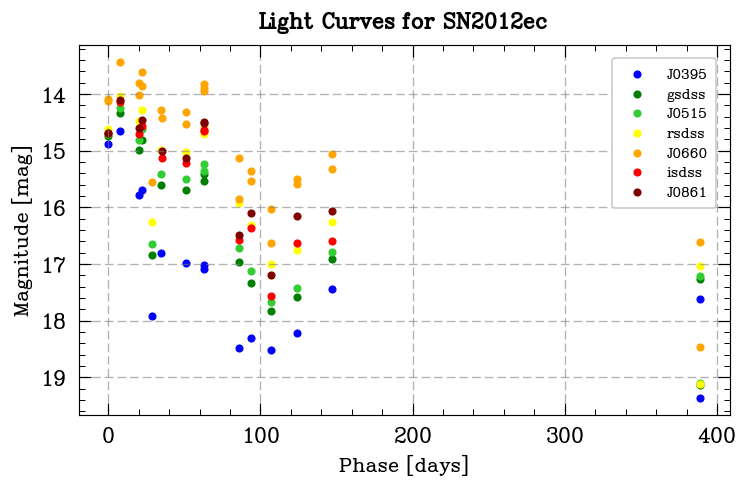

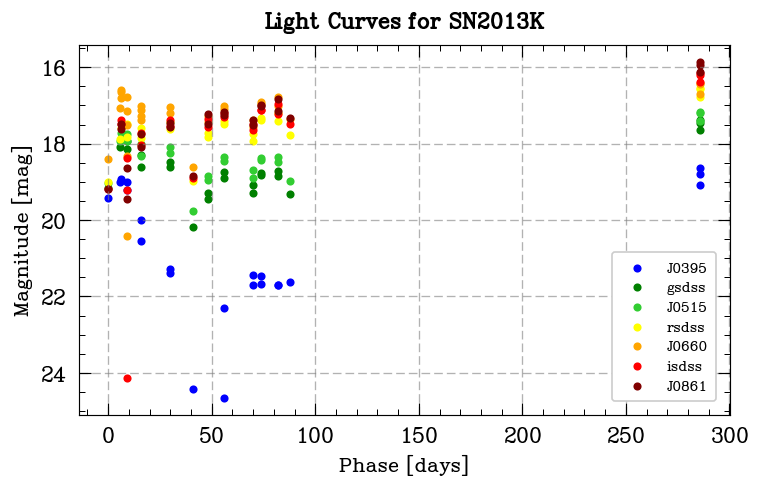

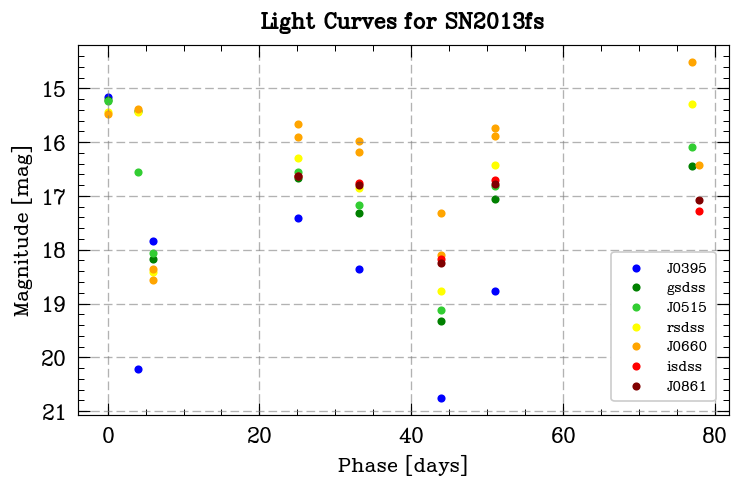

In [19]:
def plot_light_curves_for_supernova(supernova_data, bands, supernova_name):
    """
    Plots light curves for a single supernova across different bands with specific colors for each band.

    Parameters:
    supernova_data (Table): Astropy table containing data for one supernova.
    bands (list of str): List of band names to be plotted.
    supernova_name (str): Name of the supernova, used for the plot title.
    """
    # Define a color map for the bands
    color_map = {
        'J0395': 'blue',
        'gsdss': 'green',
        'J0515': 'limegreen',
        'rsdss': 'yellow',
        'J0660': 'orange',
        'isdss': 'red',
        'J0861': 'maroon'
    }

    # Extract time and magnitudes
    time = supernova_data['time']
    mag = {band: supernova_data[f"{band}_mag"] for band in bands}
    flux = {band: supernova_data[f"{band}_flux"] for band in bands}

    # Normalize time to days since start
    JD = time - np.min(time)

    plt.figure(figsize=(7, 4))

    # Plot data for each band with a specific color
    for band in bands:
        color = color_map.get(band, 'black')  # Default to black if band not in color_map
        plt.scatter(JD, mag[band], label=f'{band}', color=color, s=15)

    plt.xlabel('Phase [days]', fontsize=14)
    plt.ylabel('Magnitude [mag]', fontsize=14)
    plt.title(f'Light Curves for {supernova_name}', fontsize=16, fontweight='bold')
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.legend(fontsize=10, frameon=True)
    plt.show()

# Define bands
bands = ['J0395', 'gsdss', 'J0515', 'rsdss', 'J0660', 'isdss', 'J0861']

# Set meta information for each supernova table
SN2012ec_sncosmo.meta = {'name': 'SN2012ec'}
SN2013K_sncosmo.meta = {'name': 'SN2013K'}
SN2013fs_sncosmo.meta = {'name': 'SN2013fs'}

# List of supernova data tables with their names
supernova_data_list = [
    (SN2012ec_sncosmo, 'SN2012ec'),
    (SN2013K_sncosmo, 'SN2013K'),
    (SN2013fs_sncosmo, 'SN2013fs')
]

# Plot light curves for each supernova
for supernova_data, supernova_name in supernova_data_list:
    plot_light_curves_for_supernova(supernova_data, bands, supernova_name)

### 4.3. Light curves using synthetic photometry (synphot)

In this subsection, we will again represent the light curves using synthetic photometry. However, instead of `sncosmo`, `synphot` will be used. First, we introduce the different filters.

In [20]:
# We introduce filters in synphot
filter_gSDSS = SpectralElement.from_file('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.gSDSS.dat')
filter_rSDSS = SpectralElement.from_file('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.rSDSS.dat')
filter_iSDSS = SpectralElement.from_file('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.iSDSS.dat')
filter_J0395 = SpectralElement.from_file('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.J0395.dat')
filter_J0515 = SpectralElement.from_file('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.J0515.dat')
filter_J0660 = SpectralElement.from_file('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.J0660.dat')
filter_J0861 = SpectralElement.from_file('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.J0861.dat')

# Function to calculate magnitudes from the spectra of a SN
def calculate_bandflux_table(supernova_data, bands, bands_names):
    # List to store results
    time_list = []
    mag_dict = {name: [] for name in bands_names}

    # Loop through the data
    for i in tqdm(range(len(supernova_data['TMID']))):
        wave = supernova_data['WAVE'][i]
        flux = supernova_data['FLUX'][i]
        fluxerr = supernova_data['ERR'][i]
        time = supernova_data['TMID'][i]

        # Filter NaN values
        mask = ~np.isnan(wave) & ~np.isnan(flux) & ~np.isnan(fluxerr)
        wave_clean = wave[mask]
        flux_clean = flux[mask]
        fluxerr_clean = fluxerr[mask]

        # Model
        temperature = 5000  # Ejemplo de temperatura en Kelvin
        bb_model = BlackBodyNorm1D(temperature=temperature)

        # Create Spectrum object
        spectrum = SourceSpectrum(bb_model, points=wave_clean, lookup_table=flux_clean)

        # Add time
        time_list.append(time)

        # Calculate bandflux for each band
        for band, name in zip(bands, bands_names):
            obs = Observation(spectrum, band)
            try:
                mag = obs.effstim('abmag'); mag = mag.value
            except ValueError:
                mag = np.nan  # Assign NaN in case of error

            # Add magnitude to the dictionary
            mag_dict[name].append(mag)

    # Create an astropy table for the results
    columns = [time_list] + [mag_dict[band] for band in bands_names]
    names = ['time'] + [f"{band}_mag" for band in bands_names]
    table = Table(columns, names=names)
    table.sort('time')
    return table

# List of bands
bands = [filter_J0395, filter_gSDSS, filter_J0515, filter_rSDSS, filter_J0660, filter_iSDSS, filter_J0861]
bands_names = ['J0395', 'gsdss', 'J0515', 'rsdss', 'J0660', 'isdss', 'J0861']

# Calculate tables for each supernova
SN2012ec_synphot = calculate_bandflux_table(SN2012ec, bands, bands_names)
SN2013K_synphot = calculate_bandflux_table(SN2013K, bands, bands_names)
SN2013fs_synphot = calculate_bandflux_table(SN2013fs, bands, bands_names)
SN2013fs_synphot[0:5]

100%|███████████████████████████████████████████| 16/16 [00:03<00:00,  5.03it/s]


time,J0395_mag,gsdss_mag,J0515_mag,rsdss_mag,J0660_mag,isdss_mag,J0861_mag
float64,float64,float64,float64,float64,float64,float64,float64
56575.0513684,16.411102174615092,16.010779829246307,15.701547258184451,15.352472408101349,15.160232359792008,15.078900307946206,14.96337740365924
56579.0955049,16.411102174615092,16.010779829246307,15.701547258184451,15.352472408101349,15.160232359792008,15.078900307946206,14.96337740365924
56581.0821257,16.411102174615092,16.010779829246307,15.701547258184451,15.352472408101349,15.160232359792008,15.078900307946206,14.96337740365924
56581.0931223,16.411102174615092,16.010779829246307,15.701547258184451,15.352472408101349,15.160232359792008,15.078900307946206,14.96337740365924
56600.1589835,16.411102174615092,16.010779829246307,15.701547258184451,15.352472408101349,15.160232359792008,15.078900307946206,14.96337740365924


We plot the light curves.

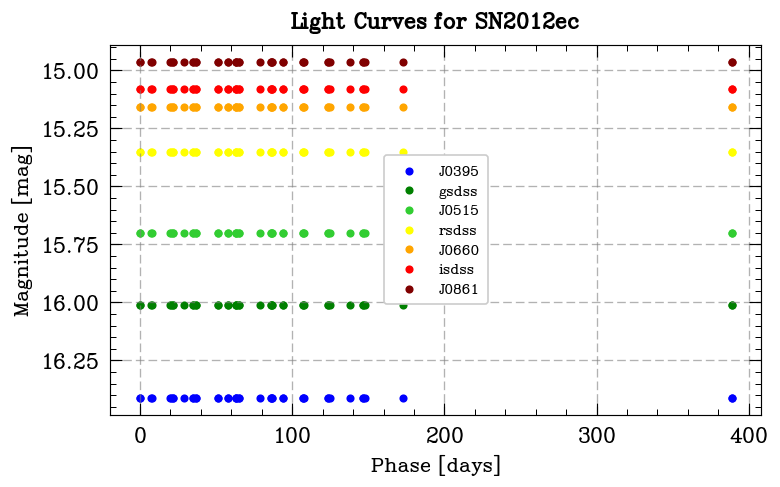

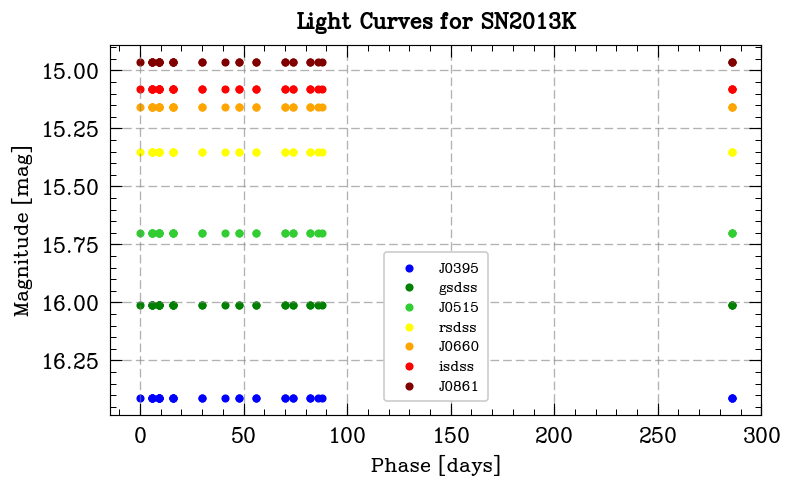

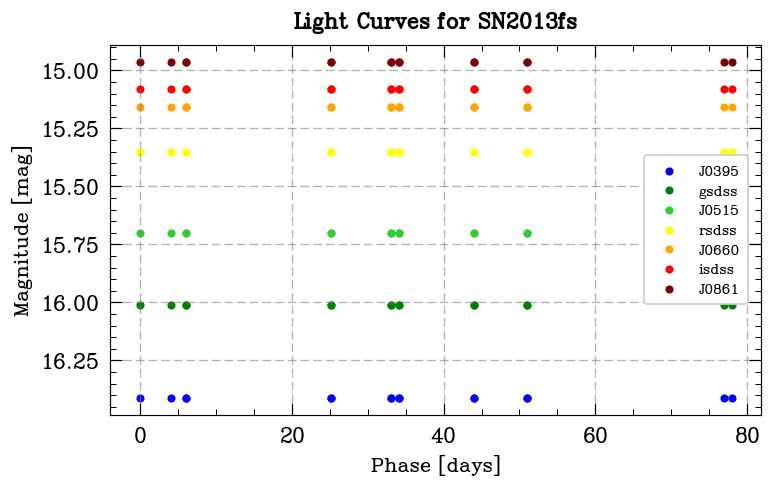

In [21]:
def plot_light_curves_for_supernova(supernova_data, bands, supernova_name):
    """
    Plots light curves for a single supernova across different bands with specific colors for each band.

    Parameters:
    supernova_data (Table): Astropy table containing data for one supernova.
    bands (list of str): List of band names to be plotted.
    supernova_name (str): Name of the supernova, used for the plot title.
    """
    # Define a color map for the bands
    color_map = {
        'J0395': 'blue',
        'gsdss': 'green',
        'J0515': 'limegreen',
        'rsdss': 'yellow',
        'J0660': 'orange',
        'isdss': 'red',
        'J0861': 'maroon'
    }

    # Extract time and magnitudes
    time = supernova_data['time']
    mag = {band: supernova_data[f"{band}_mag"] for band in bands}

    # Normalize time to days since start
    JD = time - np.min(time)

    plt.figure(figsize=(7, 4))

    # Plot data for each band with a specific color
    for band in bands:
        color = color_map.get(band, 'black')  # Default to black if band not in color_map
        plt.scatter(JD, mag[band], label=f'{band}', color=color, s=15)

    plt.xlabel('Phase [days]', fontsize=14)
    plt.ylabel('Magnitude [mag]', fontsize=14)
    plt.title(f'Light Curves for {supernova_name}', fontsize=16, fontweight='bold')
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.legend(fontsize=10, frameon=True)
    plt.show()

# Define bands
bands = ['J0395', 'gsdss', 'J0515', 'rsdss', 'J0660', 'isdss', 'J0861']

# Set meta information for each supernova table
SN2012ec_synphot.meta = {'name': 'SN2012ec'}
SN2013K_synphot.meta = {'name': 'SN2013K'}
SN2013fs_synphot.meta = {'name': 'SN2013fs'}

# List of supernova data tables with their names
supernova_data_list = [
    (SN2012ec_synphot, 'SN2012ec'),
    (SN2013K_synphot, 'SN2013K'),
    (SN2013fs_synphot, 'SN2013fs')
]

# Plot light curves for each supernova
for supernova_data, supernova_name in supernova_data_list:
    plot_light_curves_for_supernova(supernova_data, bands, supernova_name)

### 4.4. Light curves using synthetic photometry (pyphot)

In this subsection, we will again represent the light curves using synthetic photometry. However, instead of `sncosmo`, `pyphot` will be used. First, we introduce the different filters.

In [22]:
# List of bands with specified units
wave_bands = [wavelength_J0395, wavelength_gsdss, wavelength_J0515, wavelength_rsdss, wavelength_J0660, wavelength_isdss, wavelength_J0861]
transmission_bands = [transmission_J0395, transmission_gsdss, transmission_J0515, transmission_rsdss, transmission_J0660, transmission_isdss, transmission_J0861]
bands_names = ['J0395', 'gsdss', 'J0515', 'rsdss', 'J0660', 'isdss', 'J0861']


We plot the light curves.

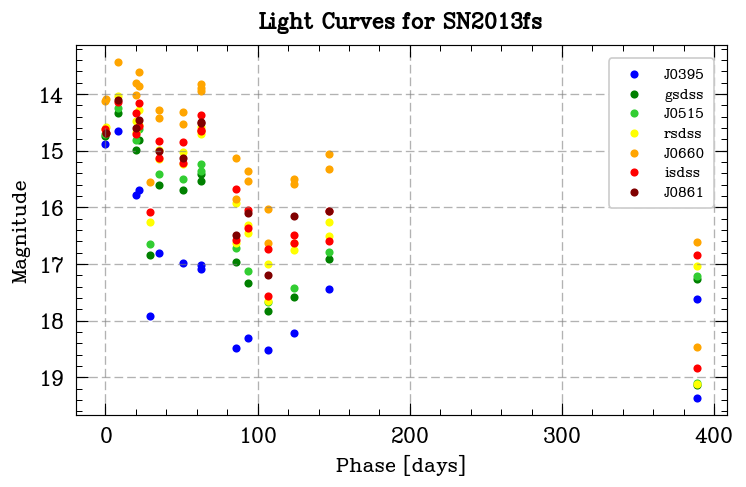

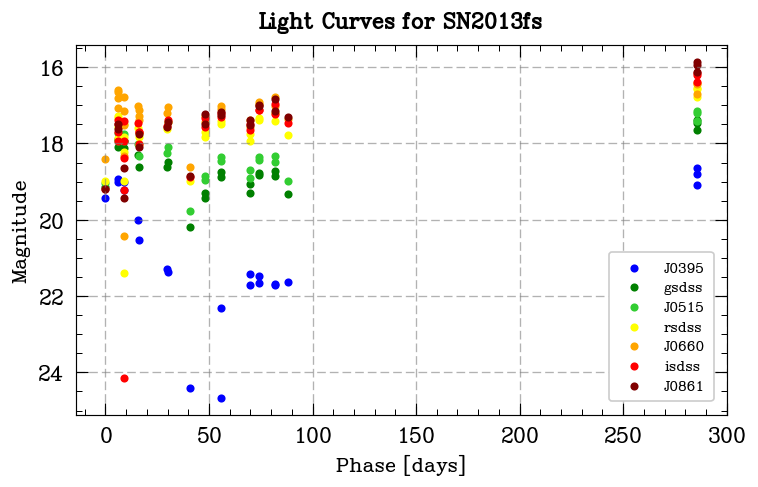

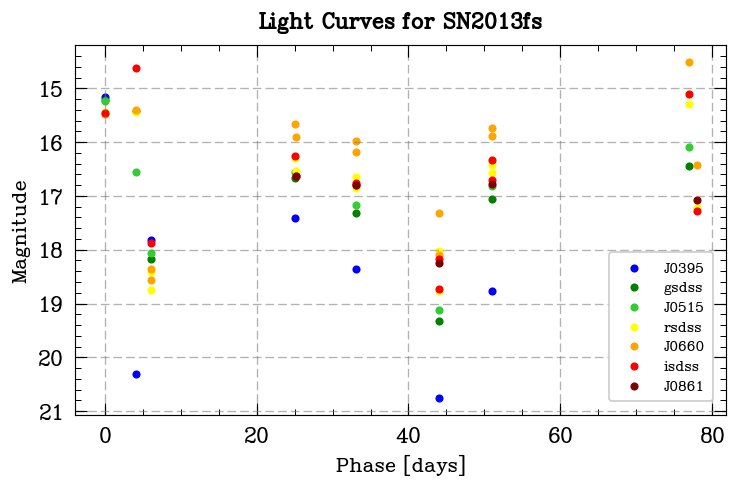

In [23]:
def calculate_magnitudes(supernova_data, wave_bands, transmission_bands, bands_names):
    # Color map for the bands
    color_map = {
        'J0395': 'blue',
        'gsdss': 'green',
        'J0515': 'limegreen',
        'rsdss': 'yellow',
        'J0660': 'orange',
        'isdss': 'red',
        'J0861': 'maroon'
    }
    
    # Create a figure for plotting
    plt.figure(figsize=(7, 4))
    
    for i, (wavelength_band, transmission_band, band_name) in enumerate(zip(wave_bands, transmission_bands, bands_names)):
        mags = []
        times = []
        
        # Convert bands to pyphot units
        wavelength_band = wavelength_band * pyphot.unit['AA']
        transmission_band = transmission_band * pyphot.unit['AA']
        
        for j in range(len(supernova_data['WAVE'])):
            wavelength = supernova_data['WAVE'][j] * pyphot.unit['AA']
            flux = supernova_data['FLUX'][j] * pyphot.unit['erg/s/cm**2/AA']
            time = supernova_data['TMID'][j]
            
            # Remove NaN values from wavelength and flux
            mask = ~np.isnan(wavelength) & ~np.isnan(flux)
            wavelength_clean = wavelength[mask]
            flux_clean = flux[mask]
            
            # Create Filter object for the current band
            f = pyphot.Filter(wavelength_band, transmission_band, name=band_name, unit='Angstrom')
            flux_band = f.get_flux(wavelength_clean, flux_clean)
            
            # Calculate magnitude
            mag = -2.5 * np.log10(flux_band) - f.AB_zero_mag
            mags.append(mag)
            times.append(time)
        
        # Convert lists to arrays for easier plotting
        mags = np.array(mags)
        times = np.array(times)
        
        # Plot magnitudes for the current band
        plt.scatter(times - np.min(times), mags, s=15, label=band_name, color=color_map.get(band_name, 'black'))
    
    # Finalize the plot
    plt.gca().invert_yaxis()
    plt.grid()
    plt.xlabel('Phase [days]', fontsize=14)
    plt.ylabel('Magnitude', fontsize=14)
    plt.legend(fontsize=10, frameon=True)
    plt.title(f'Light Curves for {supernova_name}', fontsize=16, fontweight='bold')
    plt.show()

# Usage of the function
calculate_magnitudes(SN2012ec, wave_bands, transmission_bands, bands_names)
calculate_magnitudes(SN2013K, wave_bands, transmission_bands, bands_names)
calculate_magnitudes(SN2013fs, wave_bands, transmission_bands, bands_names)

### 4.5. Light curves using synthetic photometry (our function)

In this subsection, we will again represent the light curves using synthetic photometry. However, instead of `sncosmo`, `calcular_magnitud` will be used, that is our own created function. First, we introduce the different filters.

### 4.6 Light curves using spectra

In this subsection, we plot the light curves using the spectra. For this, the `sncosmo` package will be used.

      success: True
      message: 'Minimization exited successfully.'
        ncall: 77
        chisq: 91459386.63661121
         ndof: 41843
  param_names: ['z', 't0', 'amplitude']
   parameters: array([8.04000000e-04, 5.61352638e+04, 1.56262710e-06])
 vparam_names: ['t0', 'amplitude']
   covariance: array([[ 6.70405838e-06, -1.43836476e-13],
       [-1.43836476e-13,  1.09420831e-20]])
       errors: OrderedDict([('t0', 0.0025892196463246364), ('amplitude', 1.046044126161629e-10)])
         nfit: 1
    data_mask: None


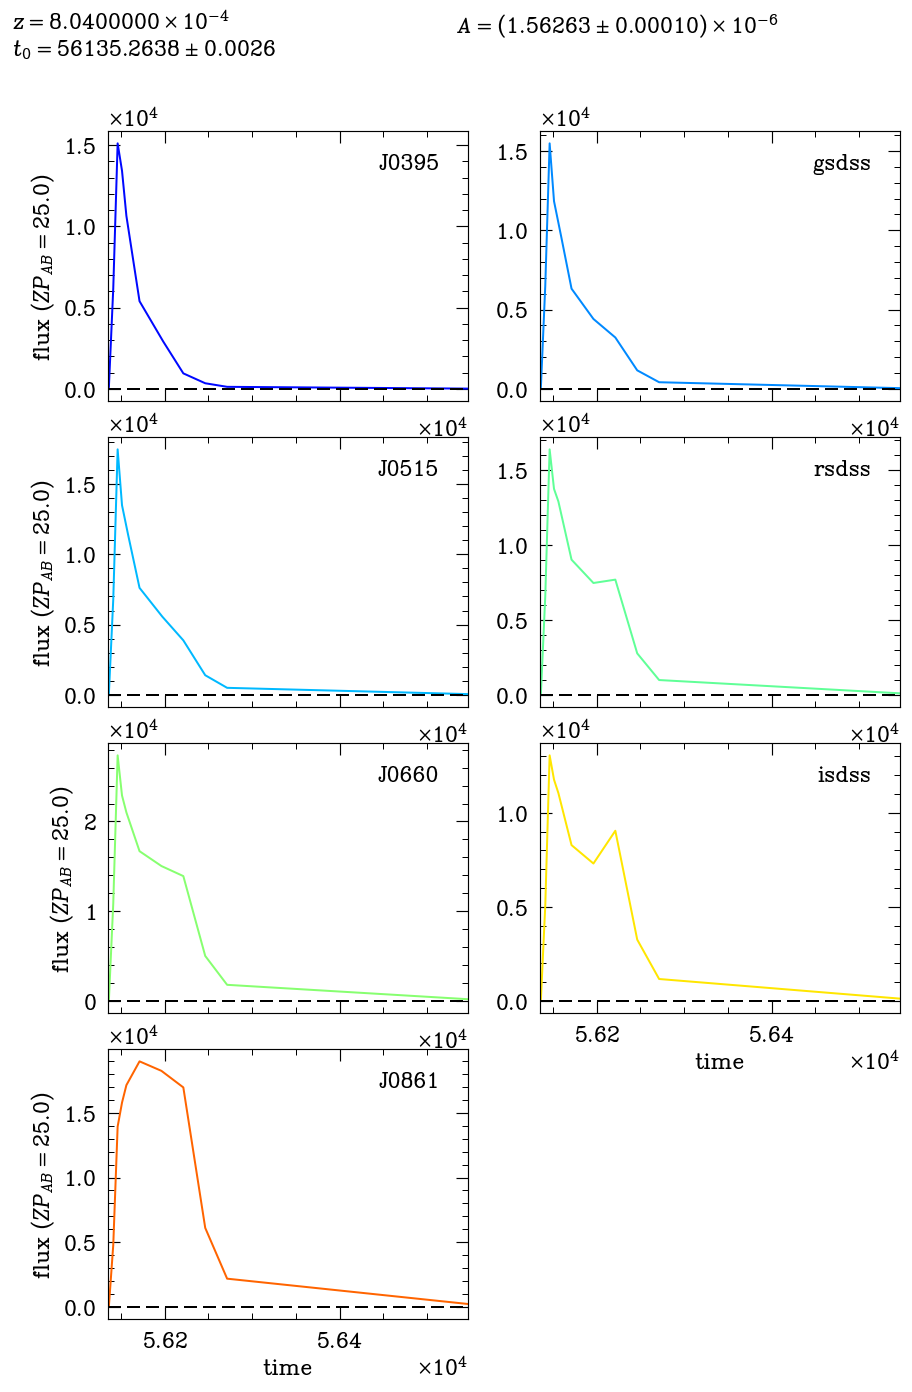

In [24]:
# Define the acceptable wavelength range for the model
min_wave = 1000
max_wave = 25000

# Create a list to store the filtered spectra
spectrum = []

for i in range(len(SN2012ec['TMID'])):
    wave = SN2012ec['WAVE'][i]
    flux = SN2012ec['FLUX'][i]
    fluxerr = SN2012ec['ERR'][i]
    time = SN2012ec['TMID'][i] 

    # Mask to filter out NaN values and keep within model's wavelength range
    mask = (~np.isnan(wave) & ~np.isnan(flux) & ~np.isnan(fluxerr) &
            (wave >= min_wave) & (wave <= max_wave))
    
    wave_clean = wave[mask]
    flux_clean = flux[mask]
    fluxerr_clean = fluxerr[mask]

    spectrum_i = sncosmo.Spectrum(wave_clean, flux_clean, fluxerr_clean, time=time)
    spectrum.append(spectrum_i)

# Define and configure the model
model = sncosmo.Model(source='nugent-sn2p')
model.set(z=0.000804)

# Fit the light curve
result, fitted_model = sncosmo.fit_lc(model=model, spectra=spectrum, vparam_names=['t0', 'amplitude'])
print(result)
# Plot the light curve using valid SDSS band names
sncosmo.plot_lc(model=fitted_model, errors=result.errors, bands=['J0395', 'gsdss', 'J0515', 'rsdss', 'J0660', 'isdss', 'J0861'])
plt.show()

We obtain a high value of _chisq_, so the model can represent the observation quite well.

## Appendix A: SN2009ip

### Data

In [25]:
SN2009ip = PESSTO[PESSTO['OBJECT'] == 'SN2009ip'] # SN2013fs
SN2009ip[:3]

OBJECT,RA,DEC,WAVE,FLUX,ERR,TMID,TRANSIENT_CLASSIFICATION_REDSHIFT,TRANSIENT_CLASSIFICATION,TRANSIENT_CLASSIFICATION_PHASE,TRANSIENT_CLASSIFICATION_PHASE_DAYS_LOWER_LIMIT,TRANSIENT_CLASSIFICATION_PHASE_DAYS_UPPER_LIMIT,TRANSIENT_DISCOVERY_MJD
,,,,,,,,,,d,d,d
str27,float64,float64,float32[1024],float32[1024],float32[1024],float64,float32,str13,bytes20,float64,float64,float64
SN2009ip,335.78467,-28.947779,14988.23 .. 25376.664,1.5614469e-16 .. 2.7248126e-16,2.9813792e-18 .. 6.506783e-18,56217.2386391,0.0059,SN IIn,post-max,11.0,20.0,55069.0
SN2009ip,335.78467,-28.947779,3345.9675 .. nan,2.7949248e-14 .. nan,2.6373774e-16 .. nan,56209.0213115,0.0059,SN IIn,post-max,11.0,20.0,55069.0
SN2009ip,335.78467,-28.947779,3340.764 .. nan,5.5404587e-17 .. nan,1.9266582e-17 .. nan,56547.0228106,0.0059,SN IIn,post-max,11.0,20.0,55069.0


### Spectra vs time

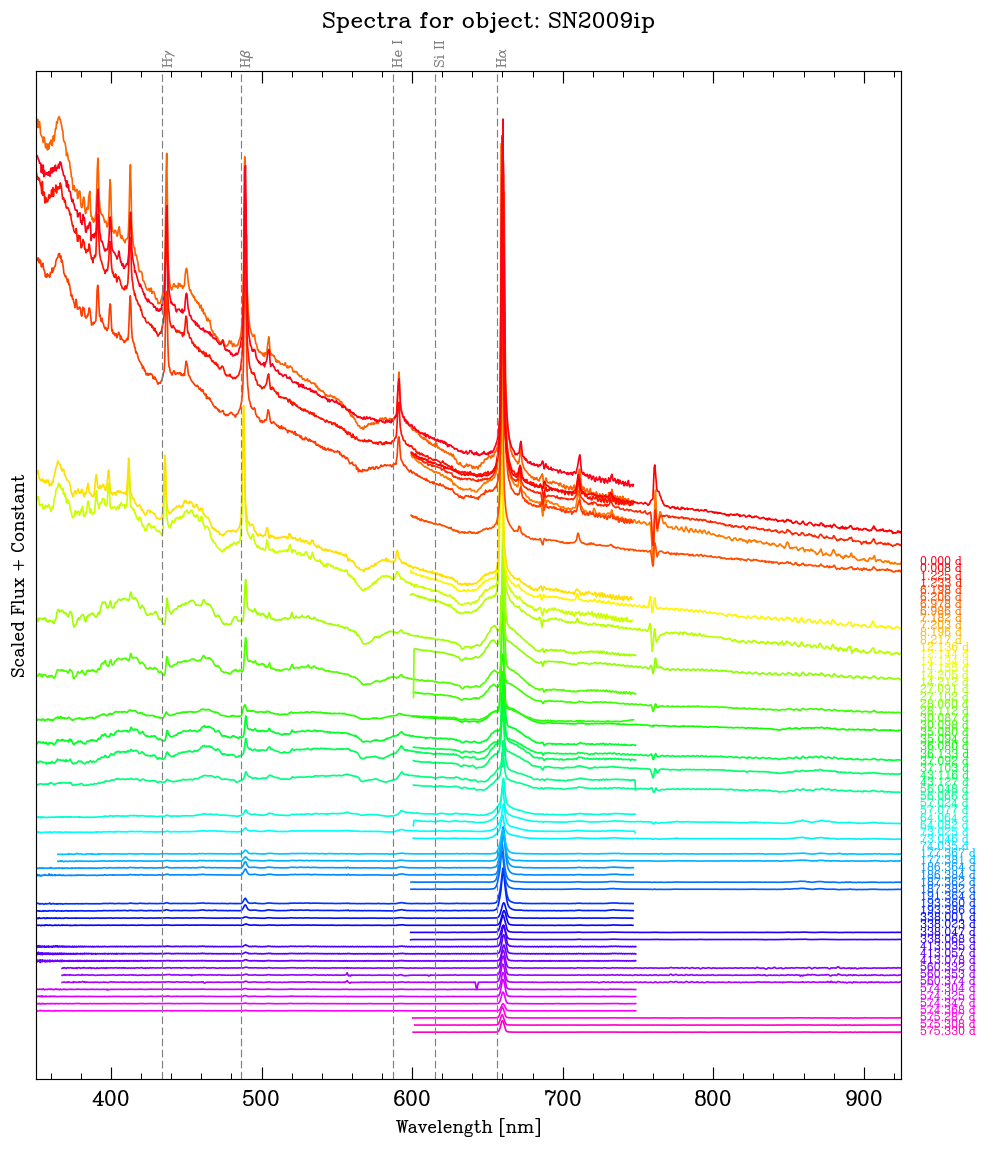

In [26]:
# Choose object
object_name = 'SN2009ip' # SN2017ens

# Get the indexes for the selected object
indices = [i for i, obj in enumerate(PESSTO['OBJECT']) if obj == object_name]

# Sort indices based on PESSTO["TMID"] values, in descending order
indices.sort(key=lambda idx: PESSTO["TMID"][idx], reverse=True)

# Create the figure
fig, ax = plt.subplots(figsize=(10, 10))

# Define the colormap
norm = plt.Normalize(0, len(indices))
cmap = cm.get_cmap('gist_rainbow_r')

# Convert from Å to nm
important_lines = {
    'Hα': 656.279,
    'Hβ': 486.135,
    'Hγ': 434.0472,
    'He I': 587.59663,
    'Si II': 615.0
}

# Search of max wavelength
maxs = []
tmin = []
for i, idx in enumerate(indices):
    wave = PESSTO['WAVE'][idx] / 10  # Convert from Å to nm
    flux = PESSTO['FLUX'][idx]
    time = PESSTO["TMID"][idx]

    maxs.append(max(wave))
    tmin.append(time)

# Iterate over each index and plot the spectrum
for i, idx in enumerate(indices):
    wave = PESSTO['WAVE'][idx] / 10  # Convert from Å to nm
    flux = PESSTO['FLUX'][idx]
    
    # Offset each spectrum vertically
    offset = i * 5.  # Adjust this value to control the separation between spectra
    ax.plot(wave, flux * 10**16. + offset, color=cmap(norm(i)), linewidth=1)
    
    # Add date text to the right of the spectrum, outside the visible plot area
    ax.text(max(maxs) - 1600, offset, f'{PESSTO["TMID"][idx]-min(tmin):.3f} d', color=cmap(norm(i)), verticalalignment='center', fontsize=8)

# Plot important lines
for line_name, line_wave in important_lines.items():
    ax.axvline(x=line_wave, color='gray', linestyle='--', linewidth=0.7)
    ax.text(line_wave, ax.get_ylim()[1]+2.8, line_name, rotation=90, verticalalignment='bottom', fontsize=10, color='gray')

# Labels and title
ax.set_xlabel('Wavelength [nm]', fontsize=12)
ax.set_ylabel('Scaled Flux + Constant', fontsize=12)
ax.yaxis.set_ticks([])
ax.yaxis.set_ticklabels([])
ax.set_xlim(350,925)

# Set x-axis format to display values as 300, 400, 500, etc.
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

fig.suptitle(f'Spectra for object: {object_name}', fontsize=16, y=0.96, x=0.42)  # Adjust y to bring the title closer

# Adjust the layout and display the graph
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust rect to make space for the legend

#plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/spectra_vs_time2.pdf')
plt.show()

### Light curve plane

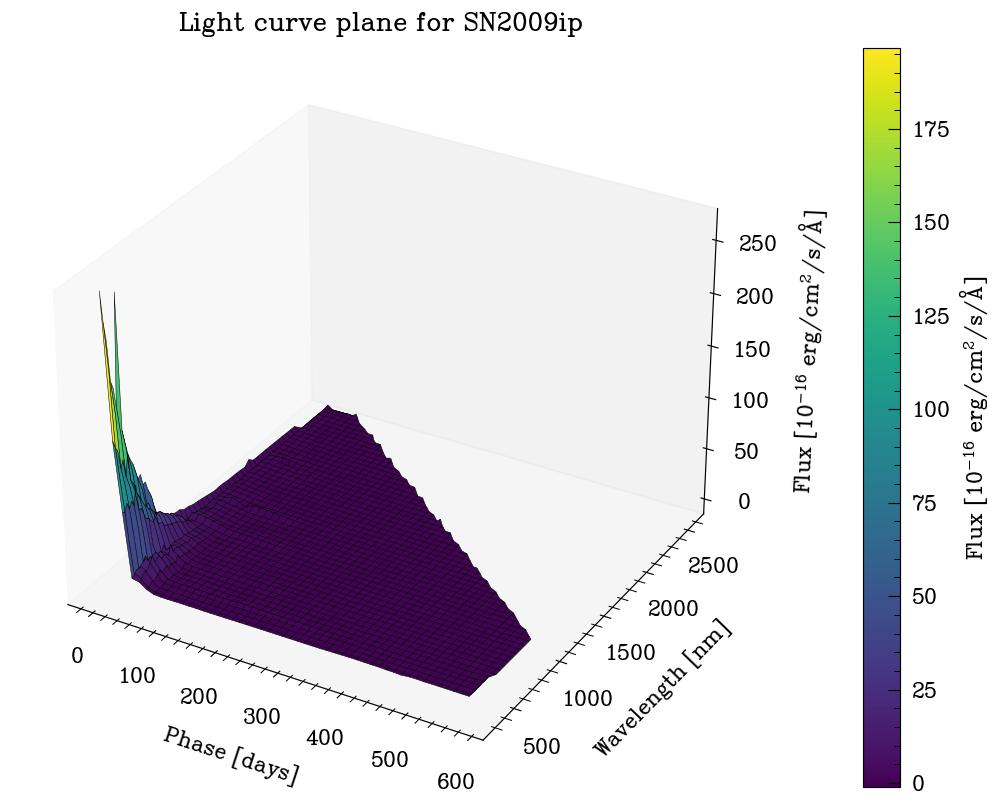

In [27]:
# Filter the table to get only the rows corresponding to the object SN2017ens
object_name = 'SN2009ip'
filtered_data = PESSTO[PESSTO['OBJECT'] == object_name]

# Extract the necessary data
wavelengths = filtered_data['WAVE'] / 10
fluxes = filtered_data['FLUX']
times = filtered_data['TMID']

# Ensure the data is in the correct format for 3D plotting
time_list = []
wavelength_list = []
flux_list = []

# Iterate over observations and add data to lists
for i, time in enumerate(times):
    valid_indices = ~np.isnan(wavelengths[i]) & ~np.isnan(fluxes[i])
    time_list.extend([time] * np.sum(valid_indices))
    wavelength_list.extend(np.array(wavelengths[i])[valid_indices])
    flux_list.extend(np.array(fluxes[i])[valid_indices])

# Convert lists to NumPy arrays
time_array = np.array(time_list)
wavelength_array = np.array(wavelength_list)
flux_array = np.array(flux_list)

# Create a grid of time and wavelength values
time_grid, wavelength_grid = np.meshgrid(
    np.linspace(time_array.min(), time_array.max(), 100),
    np.linspace(wavelength_array.min(), wavelength_array.max(), 100)
)

# Interpolate the flux values on the grid
flux_grid = griddata(
    (time_array, wavelength_array),
    flux_array,
    (time_grid, wavelength_grid),
    method='linear'
)

# Set up the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(time_grid-np.min(time_grid), wavelength_grid, flux_grid*10**16, cmap='viridis', edgecolor='black', linewidth=0.3)

# Add labels and title
ax.grid(False)
ax.set_xlabel('Phase [days]', labelpad=15)
ax.set_ylabel('Wavelength [nm]', labelpad=15)
ax.set_zlabel('Flux [10$^{-16}$ erg/cm$^2$/s/Å]', labelpad=15)
ax.set_title(f'Light curve plane for {object_name}')

# Format the wavelength axis
ax.ticklabel_format(axis='y', style='plain')

# Add a color bar
cbar = plt.colorbar(surf, shrink=1., aspect=20, pad=0.1)
cbar.set_label('Flux [10$^{-16}$ erg/cm$^2$/s/Å]')

#plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/SN2009ip_plane.pdf')
plt.show()

### Systhematic photometry

In [28]:
### Function to calculate magnitudes from the spectra of a SN
def calculate_bandflux_table(supernova_data, bands):
    # List to store results
    time_list = []
    flux_dict = {band: [] for band in bands}
    mag_dict = {band: [] for band in bands}

    # Loop through the data
    for i in range(len(supernova_data['TMID'])):
        wave = supernova_data['WAVE'][i] 
        flux = supernova_data['FLUX'][i] # - supernova_data['SKYBACK'][i] - supernova_data['BGFLUX'][i] ??
        fluxerr = supernova_data['ERR'][i]
        time = supernova_data['TMID'][i]

        # Filter NaN values
        mask = ~np.isnan(wave) & ~np.isnan(flux) & ~np.isnan(fluxerr)
        wave_clean = wave[mask]
        flux_clean = flux[mask]
        fluxerr_clean = fluxerr[mask]

        # Create Spectrum object
        spectrum = sncosmo.Spectrum(wave_clean, flux_clean, fluxerr_clean, wave_unit=u.Angstrom)

        # Add time
        time_list.append(time)

        # Calculate bandflux for each band
        for band, zp in zip(bands, zp_bands):
            try:
                flux = spectrum.bandflux(band, zpsys='ab', zp=zp)
                mag =  spectrum.bandmag(band, magsys='ab') # ab.band_flux_to_mag(flux, band)
            except ValueError:
                flux = np.nan  # Assign NaN in case of error
                mag = np.nan

            # Add flux to the dictionary
            flux_dict[band].append(flux)
            mag_dict[band].append(mag)

    # Create an astropy table for the results
    columns = [time_list] + [flux_dict[band] for band in bands] + [mag_dict[band] for band in bands]
    names = ['time'] + [f"{band}_flux" for band in bands] + [f"{band}_mag" for band in bands]
    table = Table(columns, names=names)
    table.sort('time')
    return table

# List of bands
bands = ['J0395', 'J0515', 'J0660', 'J0861', 'gsdss', 'rsdss', 'isdss']
zp_bands = [20.5018, 21.640049, 21.1636, 21.67545, 23.688549, 23.7042, 23.384201]

# Calculate tables for each supernova
SN2009ip_sncosmo = calculate_bandflux_table(SN2009ip, bands)
SN2009ip_sncosmo[0:5]

time,J0395_flux,J0515_flux,J0660_flux,J0861_flux,gsdss_flux,rsdss_flux,isdss_flux,J0395_mag,J0515_mag,J0660_mag,J0861_mag,gsdss_mag,rsdss_mag,isdss_mag
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
56209.0213115,520.4026725656709,1459.9560782891572,1328.188154987072,nan,9720.61525774903,9630.970542962601,nan,13.710951204384783,13.729199523627232,13.355450992984036,nan,13.7193146147962,13.745024863649105,nan
56209.0288651,nan,nan,1182.4144478414419,1032.1063961937457,nan,nan,5516.228958749647,nan,nan,13.481675680755483,14.141138826301852,nan,nan,14.030095290315014
56210.2462749,508.7745524087959,1393.823972713442,1293.9624349147725,nan,9327.337734866134,9114.679791072154,nan,13.73548654776636,13.779529175541827,13.38379582877037,nan,13.764154743808216,13.804846459983606,nan
56210.2538317,nan,nan,1307.0969907799386,1097.3153351239803,nan,nan,5850.206580084795,nan,nan,13.37283046295822,14.074621378590532,nan,nan,13.966272995048026
56215.2197707,433.5590517671658,1262.8106644628167,1227.7660595252755,nan,8266.127568708358,8455.083829166708,nan,13.909179355561502,13.886703397845583,13.440810941163173,nan,13.895293741659913,13.886405205421648,nan


### Light curve

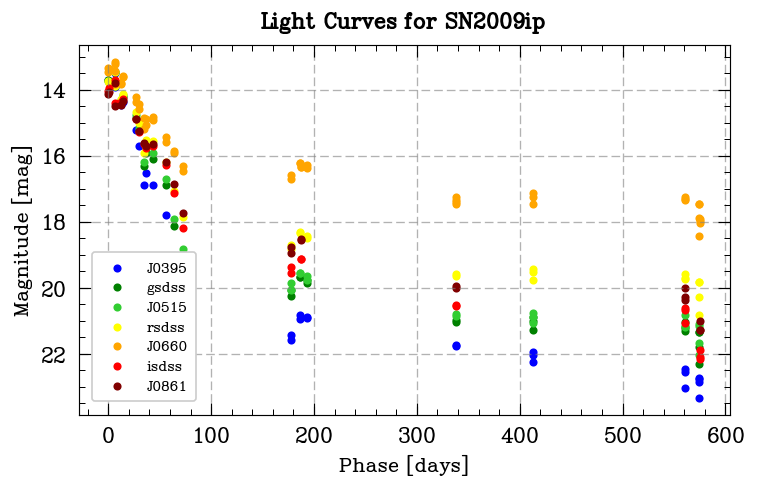

In [29]:
def plot_light_curves_for_supernova(supernova_data, bands, supernova_name):
    """
    Plots light curves for a single supernova across different bands with specific colors for each band.

    Parameters:
    supernova_data (Table): Astropy table containing data for one supernova.
    bands (list of str): List of band names to be plotted.
    supernova_name (str): Name of the supernova, used for the plot title.
    """
    # Define a color map for the bands
    color_map = {
        'J0395': 'blue',
        'gsdss': 'green',
        'J0515': 'limegreen',
        'rsdss': 'yellow',
        'J0660': 'orange',
        'isdss': 'red',
        'J0861': 'maroon'
    }

    # Extract time and magnitudes
    time = supernova_data['time']
    mag = {band: supernova_data[f"{band}_mag"] for band in bands}
    flux = {band: supernova_data[f"{band}_flux"] for band in bands}

    # Normalize time to days since start
    JD = time - np.min(time)

    plt.figure(figsize=(7, 4))

    # Plot data for each band with a specific color
    for band in bands:
        color = color_map.get(band, 'black')  # Default to black if band not in color_map
        plt.scatter(JD, mag[band], label=f'{band}', color=color, s=15)

    plt.xlabel('Phase [days]', fontsize=14)
    plt.ylabel('Magnitude [mag]', fontsize=14)
    plt.title(f'Light Curves for {supernova_name}', fontsize=16, fontweight='bold')
    plt.grid(True)
    plt.gca().invert_yaxis()
    #plt.xlim(-2,80)
    plt.legend(fontsize=10, frameon=True)
    #plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/SN2009ip.pdf')
    plt.show()

# Define bands
bands = ['J0395', 'gsdss', 'J0515', 'rsdss', 'J0660', 'isdss', 'J0861']

# Set meta information for each supernova table
SN2009ip_sncosmo.meta = {'name': 'SN2009ip'}

# List of supernova data tables with their names
supernova_data_list = [
    (SN2009ip_sncosmo, 'SN2009ip'),
]

# Plot light curves for each supernova
for supernova_data, supernova_name in supernova_data_list:
    plot_light_curves_for_supernova(supernova_data, bands, supernova_name)


### Sncosmo model

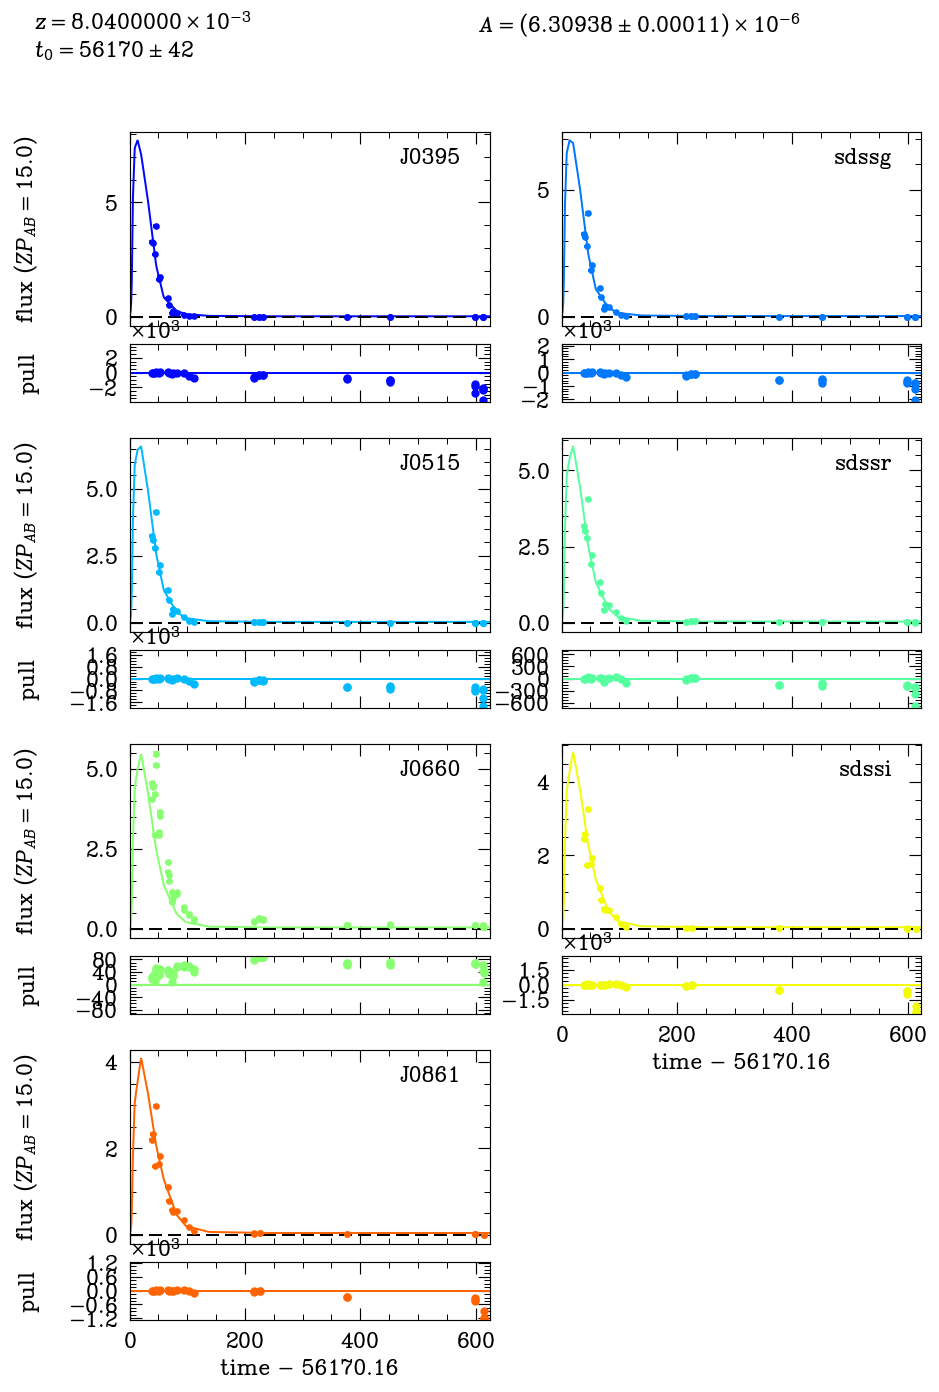

In [30]:
# Model
model = sncosmo.Model(source='nugent-sn2n')
model.set(z=0.00804)

zp = 15.0  # zero-point

# Define filter names and their corresponding magnitudes
filters = ['sdssg', 'sdssr', 'sdssi', 'J0395', 'J0515', 'J0660', 'J0861']
magnitude_columns = ['gsdss_mag', 'rsdss_mag', 'isdss_mag', 'J0395_mag', 'J0515_mag', 'J0660_mag', 'J0861_mag']
zp_bands = [20.5018, 21.640049, 21.1636, 21.67545, 23.688549, 23.7042, 23.384201]

# Create table
data = Table()

# Assign time
data['jd'] = np.concatenate([SN2009ip_sncosmo['time']] * len(filters))

# Assign the magnitudes
magnitudes = np.concatenate([SN2009ip_sncosmo[col] for col in magnitude_columns])

# Calculate fluxes
data['flux'] = 10 ** (-(magnitudes - zp) / 2.5)

# Assign the corresponding filters
filter_list = []
#zp_list = []
for f, z in zip(filters, zp_bands):
    filter_list.extend([f] * len(SN2009ip_sncosmo))
    #zp_list.extend([z] * len(SN2009ip_sncosmo))
data['filter'] = filter_list

# Assign zero-point and magnitude system
data['fluxerr'] = 0.01 * data['flux']  # assuming 5% of errors
data['zp'] = zp # zp_list
data['zpsys'] = 'ab'

# sncosmo model
bounds = {  
    't0': (2100000, 2500000),  
    'amplitude': (1e-12, 1e-6)  
}

result, fitted_model = sncosmo.mcmc_lc(data, model, ['t0', 'amplitude'], bounds=bounds, 
                                       nwalkers=10, nburn=1000, nsamples=2000, thin=5, minsnr=5)

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors, zp=zp)
plt.show()

### Light curve comparations

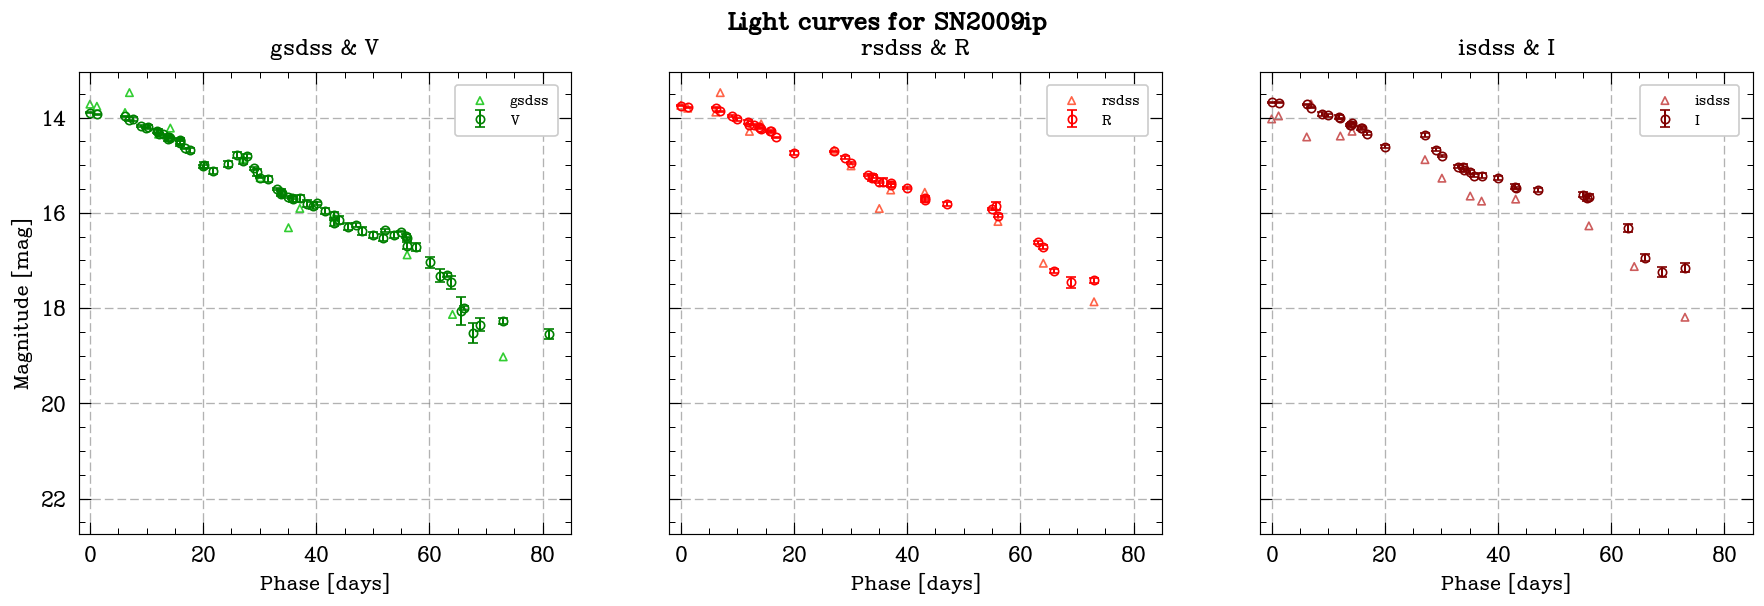

In [31]:
# Data
SN2009ip_paper = Table.read('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/PESSTO/SN2009ip.csv') # paper data

def plot_light_curves_panels(data1, data2, bands1, bands2, object_name, color_map1, color_map2, time_column1='time', time_column2='MJD', mag_suffix1='_mag', mag_suffix2='mag', error_prefix1='e_', error_prefix2='e_', s=None):
    """
    Plots light curves for a given astronomical object (e.g., supernova) across different bands with customizable colors and error bars in multiple panels.

    Parameters:
    data1, data2 (Table): Astropy tables containing columns: time, band_mag, e_band_mag.
    bands1, bands2 (list of str): List of band names to be plotted for each dataset.
    object_name (str): Name of the astronomical object, used for the plot title.
    color_map1, color_map2 (dict): Dictionaries mapping band names to colors.
    time_column1, time_column2 (str, optional): Names of the columns representing time in each dataset.
    mag_suffix1, mag_suffix2 (str, optional): Suffixes for magnitude columns in each dataset.
    error_prefix1, error_prefix2 (str, optional): Prefixes for error columns in each dataset.
    s (int): Size of dots.
    """
    if s is None:
        s = 15

    # Initialize the figure and subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    panel_pairs = [(bands1[1], bands2[2]), (bands1[3], bands2[3]), (bands1[5], bands2[4])]
    
    for i, (band1, band2) in enumerate(panel_pairs):
        ax = axs[i]
        
        # Extract time and magnitudes/fluxes
        time1 = data1[time_column1]
        time2 = data2[time_column2]
        mag1 = data1[f"{band1}{mag_suffix1}"]
        mag2 = data2[f"{band2}{mag_suffix2}"]
        
        # Extract error magnitudes/fluxes if they exist
        mag_error1 = data1[f"{error_prefix1}{band1}{mag_suffix1}"] if f"{error_prefix1}{band1}{mag_suffix1}" in data1.colnames else None
        mag_error2 = data2[f"{error_prefix2}{band2}{mag_suffix2}"] if f"{error_prefix2}{band2}{mag_suffix2}" in data2.colnames else None

        # Normalize time to days since start
        JD1 = time1 - np.min(time1)
        JD2 = time2 - np.min(time2)
        
        # Plot data for each band with specific colors and error bars if available
        color1 = color_map1.get(band1, 'black')
        color2 = color_map2.get(band2, 'black')
        
        if mag_error1 is not None:
            ax.errorbar(JD1, mag1, yerr=mag_error1, label=f'{band1}', color=color1, fmt='o', capsize=3, markersize=5, marker='^', facecolors='none')
        else:
            ax.scatter(JD1, mag1, label=f'{band1}', color=color1, s=20, marker='^', facecolors='none')
        
        if mag_error2 is not None:
            ax.errorbar(JD2, mag2, yerr=mag_error2, label=f'{band2}', color=color2, fmt='o', capsize=3, markersize=5, marker='o', mfc='none')
        else:
            ax.scatter(JD2, mag2, label=f'{band2}', color=color2, s=20, marker='o', mfc='none')
        
        ax.set_xlabel('Phase [days]', fontsize=14)
        ax.set_title(f'{band1} & {band2}', fontsize=16)
        ax.grid(True)
        ax.invert_yaxis()
        ax.legend(fontsize=10, frameon=True)
        ax.set_xlim(-2,85)
    
    axs[0].set_ylabel('Magnitude [mag]', fontsize=14)
    plt.suptitle(f'Light curves for {object_name}', fontsize=18, fontweight='bold')
    #plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/SN2009ip_comparations.pdf')
    plt.show()

color_map1 = {'J0395': 'blue', 'gsdss': 'limegreen', 'J0515': 'limegreen', 'rsdss': 'tomato', 'J0660': 'orange', 'isdss': 'indianred', 'J0861': 'maroon'}
color_map2 = {'U': 'purple', 'B': 'blue', 'V': 'green', 'R': 'red', 'I': 'maroon'}
bands_sncosmo = ['J0395', 'gsdss', 'J0515', 'rsdss', 'J0660', 'isdss', 'J0861']
bands_paper = ['U', 'B', 'V', 'R', 'I']

plot_light_curves_panels(SN2009ip_sncosmo, SN2009ip_paper, bands_sncosmo, bands_paper, 'SN2009ip', color_map1, color_map2)

## Appendix B: def function to plot light curves

In this last appendix, we include a function created by us that plot the light curves of a supernova given the data time, magnitudes and each error.

In [32]:
def plot_light_curves(data, bands, object_name, color_map, time_column='time', mag_suffix='_mag', error_prefix='e_', s=None):
    """
    Plots light curves for a given astronomical object (e.g., supernova) across different bands with customizable colors and error bars.

    Parameters:
    data (Table): Astropy table containing columns: time, band_mag, e_band_mag.
    bands (list of str): List of band names to be plotted.
    object_name (str): Name of the astronomical object, used for the plot title.
    color_map (dict, optional): Dictionary mapping band names to colors. Defaults to None, which uses a preset color scheme.
    time_column (str, optional): Name of the column representing time. Defaults to 'time'.
    mag_suffix (str, optional): Suffix for magnitude columns. Defaults to '_mag'.
    error_prefix (str, optional): Prefix for error columns. Defaults to 'e_'.
    s (int): size of dots.
    """
    if s is None:
        s = 15
    
    # Extract time and magnitudes/fluxes
    time = data[time_column]
    mag = {band: data[f"{band}{mag_suffix}"] for band in bands}
    
    # Extract error magnitudes/fluxes if they exist
    mag_error = {}
    flux_error = {}
    for band in bands:
        mag_error_col = f"{error_prefix}{band}{mag_suffix}"
        mag_error[band] = data[mag_error_col] if mag_error_col in data.colnames else None

    # Normalize time to days since start
    JD = time - np.min(time)

    plt.figure(figsize=(7, 4))

    # Plot data for each band with a specific color and error bars if available
    for band in bands:
        color = color_map.get(band, 'black')  # Default to black if band not in color_map
        if mag_error[band] is not None:
            plt.errorbar(JD, mag[band], yerr=mag_error[band], label=f'{band}', color=color, fmt='o', capsize=3, markersize=s)
        else:
            plt.scatter(JD, mag[band], label=f'{band}', color=color, s=s)

    plt.xlabel('Phase [days]', fontsize=14)
    plt.ylabel('Magnitude [mag]', fontsize=14)
    plt.title(f'Light curves for {object_name}', fontsize=16, fontweight='bold')
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.legend(fontsize=10, frameon=True)
    plt.show()

In [33]:
# Ejectuoon Time
b = time_notebook.time()
print(np.round((b-a)/60,2),'min of execution')

4.36 min of execution
